In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm



2025-07-05 09:59:28.545515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751702368.954786  133208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751702369.072876  133208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-05 09:59:30.280142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  war

In [3]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [5]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            #print("TETSTSETS", idx, cut, a_train, a_test)
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #print("aldingvapnb[", df)
        #idx = int(df.shape[0] * 0.8)#TEST_SIZE)
        #cut = int((df.shape[0]-idx)/10)
        #cut = df.iloc[idx]
        #print("IDX", idx)
        #print("CUT", cut)
        #print("DF.Values", df.values)
        #print("<CUT", df[df.Time<cut].values)
        #print(">CUT", df[df.Time>=cut].values)
        #Y_train_df = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        #Y_test_df = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test 
        #Y_train_df = df.values[:cut]
        #Y_test_df = df.values[cut:]
        #print("Stom kut ding", Y_train_df, "BAH", Y_test_df)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #return df
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")
        

In [6]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))
        test, orig_test = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))  # same for now
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg


def load_mimic_data(data_path, cluster_prefix="cluster_", n_clusters=4):
    """
    Loads clustered MIMIC time series from CSVs per cluster.

    Returns:
        lst_arrays: List of [n_samples x timesteps x features]
        df_combined: All time series as long DataFrame
    """
    lst_arrays = []
    records = []

    for cid in range(n_clusters):
        cluster_dir = os.path.join(data_path, f"{cluster_prefix}{cid}")
        csv_files = sorted([f for f in os.listdir(cluster_dir) if f.endswith(".csv")])

        for fname in csv_files:
            fpath = os.path.join(cluster_dir, fname)
            df = pd.read_csv(fpath)

            # Save 3D array
            features = df.drop(columns=["label_30d", "label_1y", "label_2y"]).values
            lst_arrays.append(features)

            # For tracking in full DataFrame
            df["cluster"] = cid
            df["sample_id"] = fname.replace(".csv", "")
            records.append(df)

    df_combined = pd.concat(records, ignore_index=True)
    return lst_arrays, df_combined


In [7]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [8]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# Parse the arguments from a string
args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated": #???
    CHANGE_COLS = [1, 2]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=512):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=True), #200 testen
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)




/tmp/ipykernel_133208/3369857583.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["index_new"]].apply(
/tmp/ipykernel_133208/3369857583.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["bolus"][data_bg["bolus"] == -1] = 0
/tmp/ipykernel_133208/3369857583.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["carbs"][data_bg["carbs

The shape of loaded train: 12*(12236, 5)
The shape of test: 12*(12236, 5)
===========Desired trend parameters=============
center: last, desired_shift: 0;
fraction_std:1;
desired_change:'sample_based', poly_order:1.
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
300 strides skipped due to NaN values.
400 strides skipped due to NaN values.
500 strides skipped due to NaN values.
600 strides skipped due to NaN values.
700 strides skipped due to NaN values.
800 strides skipped due to NaN values.
900 strides skipped due to NaN values.
1000 strides skipped due to NaN values.
1100 strides skipped due to NaN values.
1200 strides skipped due to NaN values.
1300 strides skipped due to NaN values.
1400 strides skipped due to NaN values.
1500 strides skipped due to NaN values.
1600 strides skipped due to NaN values.
1700 strides skipped due to NaN values.
1800 strides skipped due to NaN values.
1900 strides skipped due to NaN values.
2000 strides skipped due to NaN v

2025-07-05 10:00:48.318451: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200


2025-07-05 10:00:49.998123: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - ETA: 0s - loss: 0.0918

2025-07-05 10:01:38.716288: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 54s 173ms/step - loss: 0.0918 - val_loss: 0.0497
Epoch 2/200
256/256 [==============================] - 43s 167ms/step - loss: 0.0421 - val_loss: 0.0388
Epoch 3/200
256/256 [==============================] - 45s 175ms/step - loss: 0.0364 - val_loss: 0.0370
Epoch 4/200
256/256 [==============================] - 43s 169ms/step - loss: 0.0338 - val_loss: 0.0337
Epoch 5/200
256/256 [==============================] - 43s 169ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 6/200
256/256 [==============================] - 44s 171ms/step - loss: 0.0309 - val_loss: 0.0316
Epoch 7/200
256/256 [==============================] - 44s 172ms/step - loss: 0.0302 - val_loss: 0.0330
Epoch 8/200
256/256 [==============================] - 43s 168ms/step - loss: 0.0296 - val_loss: 0.0300
Epoch 9/200
256/256 [==============================] - 43s 167ms/step - loss: 0.0288 - val_loss: 0.0297
Epoch 10/200
256/256 [==============================] - 45s 176ms/step - los

2025-07-05 10:31:25.479834: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 31s 44ms/step
Epoch 1/200


2025-07-05 10:31:57.956165: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


255/256 [============================>.] - ETA: 0s - loss: 0.0677

2025-07-05 10:32:05.834930: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 9s 26ms/step - loss: 0.0677 - val_loss: 0.0401
Epoch 2/200
256/256 [==============================] - 6s 25ms/step - loss: 0.0364 - val_loss: 0.0363
Epoch 3/200
256/256 [==============================] - 6s 25ms/step - loss: 0.0342 - val_loss: 0.0344
Epoch 4/200
256/256 [==============================] - 6s 25ms/step - loss: 0.0325 - val_loss: 0.0329
Epoch 5/200
256/256 [==============================] - 6s 22ms/step - loss: 0.0316 - val_loss: 0.0329
Epoch 6/200
256/256 [==============================] - 6s 23ms/step - loss: 0.0306 - val_loss: 0.0333
Epoch 7/200
256/256 [==============================] - 7s 26ms/step - loss: 0.0304 - val_loss: 0.0316
Epoch 8/200
256/256 [==============================] - 7s 29ms/step - loss: 0.0299 - val_loss: 0.0319
Epoch 9/200
256/256 [==============================] - 7s 29ms/step - loss: 0.0294 - val_loss: 0.0315
Epoch 10/200
256/256 [==============================] - 6s 25ms/step - loss: 0.0288 - val_loss

2025-07-05 10:35:26.659170: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 4s 6ms/step


TESTTESTESTESTESTEST: (21025, 6, 5) (21025, 6, 5)
gru model trained, with test sMAPE score 6.2112; test RMSE score: 14.6965.
nbeats model trained, with test sMAPE score 5.9832; test RMSE score: 14.0949.
TEST (21025, 6) (21025, 6)


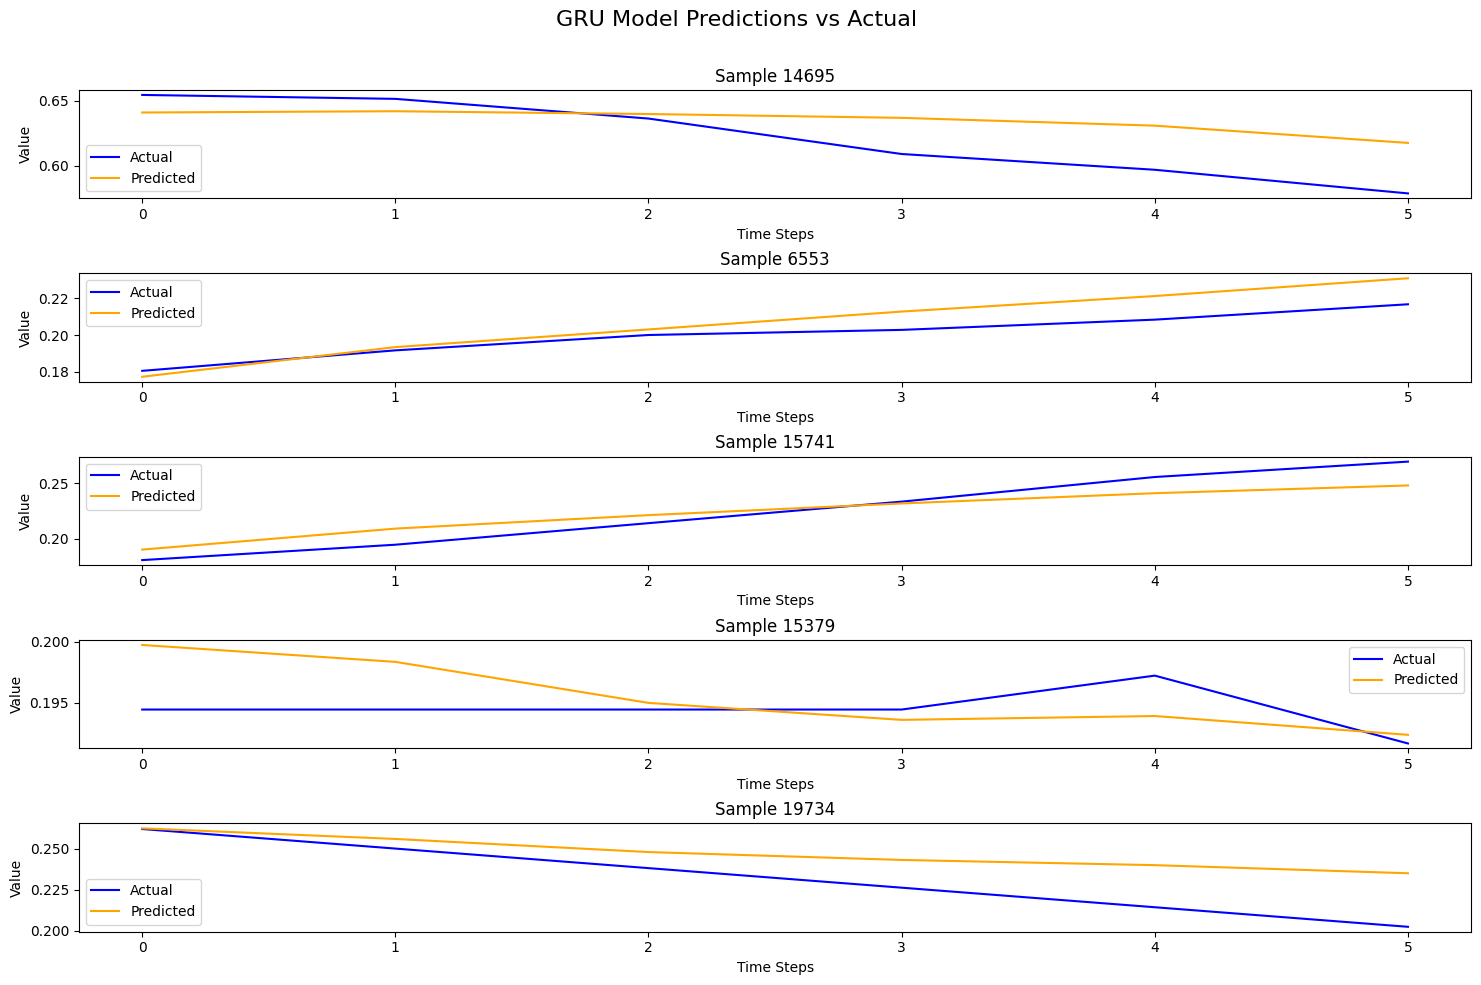

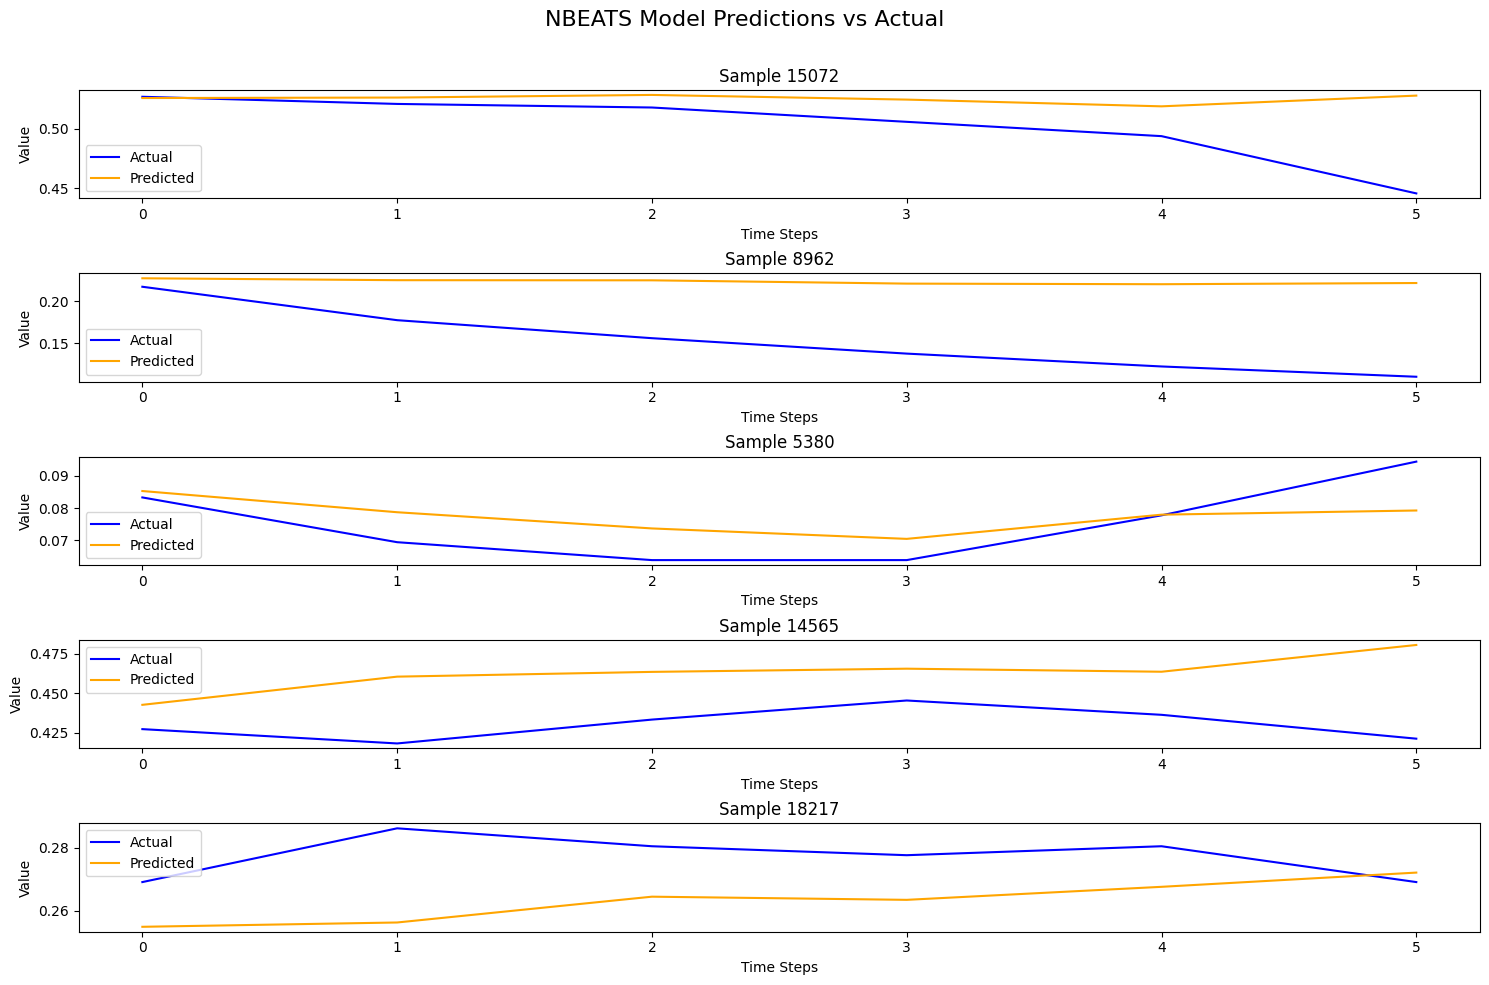

In [9]:
print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
#pred_tf_tft = pred_all_TFT[:,:,0]
#pred_tf_tft = tf.convert_to_tensor(pred_tf_tft, dtype=tf.float32)
#pred_exog_tft = pred_all_TFT[:,:,1:]
#pred_tf_nbeatsx = pred_all_NBEATSx[:,:,0]
#pred_tf_nbeatsx = tf.convert_to_tensor(pred_tf_nbeatsx, dtype=tf.float32)
#pred_exog_nbeatsx = pred_all_NBEATSx[:,:,1:]

#print(dataset.X_test_exog.shape[0], dataset.Y_test, pred_tf)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_tft)
#print(
#    f"tft model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeatsx)
#print(
#    f"nbeatsx model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()

# Assuming you have your predictions and actual values
# pred_tf is the output from your model
# dataset.Y_test is the actual target values
# Reshape predictions if necessary
pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_tft = pred_tf_tft.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_nbeatsx = pred_tf_nbeatsx.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
# Call the plotting function
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_tft, "tft", title='TFT Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeatsx, "nbeatsx", title='NBEATSx Model Predictions vs Actual')

#for i in range(dataset.X_test_exog.shape[0]):
#print(pred_tf)

In [10]:
pred_all = pred_all_NBEATS
pred_tf = pred_tf_nbeats

hyper_bound, hypo_bound = 180, 70
print(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(tf.reshape(pred_tf[i], (1, -1)).numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)

# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_reg_exog.shape[0])

Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]

print("ET", Exog_test, Target_test)

print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
desired_steps = 24 if args.dataset == "ohiot1dm" else 20
if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")

for i in range(len(Exog_test)): #???Maybe join exog, target
    idx = dataset.reg_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desired_center_scaled:0.4f}"
    #)
    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=np.transpose(Target_test[i,0]),
        desired_steps=desired_steps,
    )
    print("max", desired_max_scaled)
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    
#for i in range(X_test.shape[0]):
#    max_bound = (
#        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
#    )
#    min_bound = (
#        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
#    )


===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (7428,)
hypo_indices shape: (875,)
LSASLSLKDGNS [[151.32939 150.59346 150.6832  148.83176 147.25392 148.39743]]
hyper
if [   55    56    57 ... 21019 21020 21021]
ET [[[0.19047619 0.         0.         0.        ]
  [0.19047619 0.         0.         0.        ]
  [0.19047619 0.         0.         0.        ]
  [0.19047619 0.         0.         0.        ]
  [0.19047619 0.         0.         0.        ]
  [0.19047619 0.87719298 0.         0.        ]]

 [[0.85714286 0.         0.         0.        ]
  [0.85714286 0.         0.         0.        ]
  [0.85714286 0.         0.         0.        ]
  [0.85714286 0.         0.         0.        ]
  [0.85714286 0.         0.         0.        ]
  [0.85714286 0.         0.         0.        ]]

 [[0.89285714 0.         0.         0.        ]
  [0.89285714 0.         0.         0.        ]
  [0.89285714 0.         0.         0.        ]
  [0.

In [34]:
def get_meal_weights(x_sample, activity_threshold=0):
    # for all the variables in x_sample => 0 - weights for all positive values (i.e., larger than the threshold); more effective for bolus insulin and carbs intake

    # custom_step_weights has the same dimension as all the input variables (index needed);
    # but then only the weights for `z_change_idx` will be called
    custom_step_weights = (
        np.asarray(x_sample <= activity_threshold, dtype=np.float32) * 1
    )
    return custom_step_weights

In [36]:
class RegForecast:
    def __init__(
        self,
        max_iter=100,
        optimizer=None,
        pred_margin_weight=1.0,#???
        step_weights="local",#???
        target_col=0,
        only_change_idx=None,
        random_state=None,
    ):
        #Parameters
        self.optimizer_ = (
            tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
            if optimizer is None
            else optimizer
        )
        self.mse_loss = tf.keras.losses.MeanSquaredError()
        #self.tolerance???
        self.max_iter = max_iter
        #weights of loss components
        self.pred_margin_weight = pred_margin_weight
        self.weighted_steps_weight = 1 - self.pred_margin_weight
        self.step_weights = step_weights
        self.random_state = random_state
        self.target_col = target_col
        self.MISSING_MAX_BOUND = np.inf
        self.MISSING_MIN_BOUND = -np.inf
    def fit(self, model):
        self.model = model
        return self

    def predict(self, x):
        if
        return self.model(x)

    def margin_mse(self, prediction, max_bound, min_bound): #???
        masking_vector = tf.logical_not(
            tf.logical_and(prediction <= max_bound, prediction >= min_bound)
        )
        unmasked_preds = tf.boolean_mask(prediction, masking_vector)

        if unmasked_preds.shape == 0:
            return 0

        mse_loss_ = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.SUM
        )

        if tf.reduce_any(max_bound != self.MISSING_MAX_BOUND):
            dist_max = mse_loss_(max_bound, unmasked_preds)
        else:
            dist_max = 0

        if tf.reduce_any(min_bound != self.MISSING_MIN_BOUND):
            dist_min = mse_loss_(min_bound, unmasked_preds)
        else:
            dist_min = 0

        return dist_max + dist_min
    def weighted_mape(#???
        self,
        original_per_feature,
        cf_per_feature,
        step_weights,
    ):
        # note: the output can be arbitrarily high when `original_per_feature` is small (which is specific to the metric)
        # src: https://github.com/scikit-learn/scikit-learn/blob/80598905e517759b4696c74ecc35c6e2eb508cff/sklearn/metrics/_regression.py#L296
        denum = tf.math.maximum(
            tf.math.abs(original_per_feature), tf.keras.backend.epsilon()
        )
        mape_score = tf.math.abs(original_per_feature - cf_per_feature) / denum
        weighted_mape = tf.math.multiply(ape_score, step_weights)
        return tf.math.reduce_mean(weighted_mape)

    def compute_loss(
        self,
        original_sample,
        z_search,
        step_weights,
        max_bound,
        min_bound,
        n_iter=None,
    ):
        loss = tf.zeros(shape=())
        pred = self.model_(z_search)

        forecast_margin_loss = self.margin_mse(pred, max_bound, min_bound)
        loss += self.pred_margin_weight * forecast_margin_loss

        # weighted_ape for each changeable variable
        for z_idx in self.z_change_idx:
            weighted_steps_loss = self.weighted_ape(
                tf.cast(original_sample[:, :, z_idx], tf.float32),
                tf.cast(z_search[:, :, z_idx], tf.float32),
                tf.cast(step_weights[:, :, z_idx], tf.float32),
            )
            loss += self.weighted_steps_weight * weighted_steps_loss

        return loss, forecast_margin_loss, weighted_steps_loss

    def transform(
        self,
        x,
        max_bound_lst=None,
        min_bound_lst=None,
        clip_range_inputs=None,
        hist_value_inputs=None,
    ):
    
        try:
            print(
                f"Validating threshold input: {len(max_bound_lst)==x.shape[0] or len(min_bound_lst)==x.shape[0]}"
            )
        except:
            print("Wrong parameter inputs, at least one threshold should be provided.")
        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))
        for i in range(x.shape[0]):
            # if i % 25 == 0:
            print(f"{i} samples been transformed.")

            x_sample = np.expand_dims(x[i], axis=0)
            if self.step_weights == "unconstrained":
                step_weights = np.zeros(x_sample.shape)
            elif self.step_weights == "uniform":
                step_weights = np.ones(x_sample.shape)
            elif self.step_weights in ["meal", "meal_time"]:
                step_weights = get_meal_weights(x_sample)
            # if self defined arrays as input
            elif isinstance(self.step_weights, np.ndarray):
                step_weights = self.step_weights
            else:
                raise NotImplementedError(
                    "step_weights not implemented, please choose 'unconstrained', 'meal_time' or 'uniform'."
                )

            # Check the condition of desired CF: upper and lower bound
            max_bound = (
                max_bound_lst[i] if max_bound_lst != None else self.MISSING_MAX_BOUND
            )
            min_bound = (
                min_bound_lst[i] if min_bound_lst != None else self.MISSING_MIN_BOUND
            )
            print("APGBNA{QNBOE{OAN", min_bound, max_bound)
            clip_ranges = clip_range_inputs[i] if clip_range_inputs else None
            print(f"clip_ranges:{clip_ranges is not None}")
            hist_values = hist_value_inputs[i] if hist_value_inputs else None
            print(f"hist_values:{hist_values is not None}")
            cf_sample, loss = self._transform_sample(
                x_sample, step_weights, max_bound, min_bound, clip_ranges, hist_values
            )

            result_samples[i] = cf_sample
            losses[i] = loss
            weights_all[i, :, :, :] = step_weights

        return result_samples, losses, weights_all

    
    def _transform_sample(
        self, x, step_weights, max_bound, min_bound, clip_ranges=None, hist_input=None
    ):
        """Generate counterfactual explanations
        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """
        # split z_variables into z_static_idx + z_change_idx
        z_variables = list()
        if self.target_col is not None and not self.only_change_idx:
            z_static_idx = [self.target_col]
            z_change_idx = [i for i in list(range(x.shape[2])) if i not in z_static_idx]
        elif self.only_change_idx:
            # only_change_idx should be a list of idx, e.g., [2,3], TODO: add validate() function
            z_change_idx = self.only_change_idx
            z_static_idx = [i for i in list(range(x.shape[2])) if i not in z_change_idx]
        else:
            print("Not implemented, target_col/only_change_idx.")

        print(f"z_change_idx, z_static_idx:{z_change_idx, z_static_idx}")
        self.z_change_idx, self.z_static_idx = z_change_idx, z_static_idx
        # iterate over all features to create tf variables (with z_change_idx + z_static_idx)
        for dim in range(x.shape[2]):
            if clip_ranges:
                clip_low, clip_high = clip_ranges[dim]
                z = tf.Variable(
                    np.expand_dims(x[:, :, dim], axis=2),
                    dtype=tf.float32,
                    # Extra clipping step -> project constraints after apply_gradients()
                    constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high),
                    name="var" + str(dim),
                )
            else:
                z = tf.Variable(
                    np.expand_dims(x[:, :, dim], axis=2),
                    dtype=tf.float32,
                    name="var" + str(dim),
                )
            z_variables.append(z)

        it = 0
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch([z_variables[i] for i in self.z_change_idx])
            loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                x,
                tf.concat(z_variables, axis=2),
                step_weights,
                max_bound,
                min_bound,
                n_iter=it,
            )
        print(f"watched variables:{[var.name for var in tape.watched_variables()]}")

        pred = self.model_(tf.concat(z_variables, axis=2))

        # uncomment for debug
        print(
            f"iter: {it}, current loss: {loss}, forecast_margin_loss: {forecast_margin_loss}, weighted_steps_loss: {weighted_steps_loss} \ndesired range: {min_bound, max_bound} \npred:{tf.reshape(pred, [-1])} \n",
        )
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and (
            it < self.max_iter if self.max_iter else True
        ):
            # Get gradients of loss wrt the sample
            z_change_vars = [z_variables[i] for i in self.z_change_idx]
            grads = tape.gradient(loss, z_change_vars)

            # Update the weights of the sample; one grad update per feature, for z_each in z_variables
            self.optimizer_.apply_gradients(zip(grads, z_change_vars))

            # # historical_input_constraints mechanism:
            if hist_input:
                threshold_close = 0.001
                for z_idx in self.z_change_idx:
                    for step in range(z_variables[z_idx].shape[1]):
                        min_dist = tf.reduce_min(
                            tf.abs(z_variables[z_idx][:, step, :] - hist_input[z_idx])
                        )
                        if min_dist <= threshold_close:
                            step_weights[:, step, z_idx] = 1

            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch([z_variables[i] for i in self.z_change_idx])
                loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                    x,
                    tf.concat(z_variables, axis=2),
                    step_weights,
                    max_bound,
                    min_bound,
                    n_iter=it,
                )
            it += 1

            pred = self.model_(tf.concat(z_variables, axis=2))

        # uncomment for debug
        print(
            f"iter: {it}, current loss: {loss}, forecast_margin_loss: {forecast_margin_loss}, weighted_steps_loss: {weighted_steps_loss} \ndesired range: {min_bound, max_bound} \npred:{tf.reshape(pred, [-1])} \n",
        )

        res = tf.concat(z_variables, axis=2).numpy()
        return res, float(loss)

In [40]:
import numpy as np
import tensorflow as tf

class SARIMAXRegressorOptimizer:
    def __init__(
        self,
        model,  # fitted SARIMAX model (statsmodels)
        horizon,
        max_iter=100,
        optimizer=None,
        pred_margin_weight=1.0,  # for now keep 1.0, unused here
        random_state=None,
    ):
        self.model = model
        self.horizon = horizon
        self.max_iter = max_iter
        self.optimizer = (
            tf.keras.optimizers.Adam(learning_rate=1e-3)
            if optimizer is None
            else optimizer
        )
        self.pred_margin_weight = pred_margin_weight
        self.random_state = random_state

        # For missing bounds
        self.MISSING_MAX_BOUND = np.inf
        self.MISSING_MIN_BOUND = -np.inf

    def compute_loss(self, max_bound, min_bound, pred):
        mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        dist_max = mse_loss(max_bound, pred)
        dist_min = mse_loss(min_bound, pred)
        return dist_max + dist_min

    def _compute_gradient_finite_difference(self, X_e, max_bound, min_bound, epsilon=1e-4):
        """
        Approximate gradient of loss wrt input exogenous features by finite difference.
        X_e: tf.Variable of shape [timesteps, features] (exog)
        max_bound, min_bound: tensors for forecast bounds
        """
        X_np = X_e.numpy()
        base_pred = self.model.forecast(
            steps=self.horizon, start_params=self.model.params, exog=X_np
        )
        base_pred = tf.convert_to_tensor(base_pred, dtype=tf.float32)
        base_loss = self.compute_loss(max_bound, min_bound, base_pred)

        grads = np.zeros_like(X_np)
        for t in range(X_np.shape[0]):
            for f in range(X_np.shape[1]):
                X_perturbed = X_np.copy()
                X_perturbed[t, f] += epsilon

                pred_perturbed = self.model.forecast(
                    steps=self.horizon, start_params=self.model.params, exog=X_perturbed
                )
                pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

                perturbed_loss = self.compute_loss(max_bound, min_bound, pred_perturbed)

                grad = (perturbed_loss.numpy() - base_loss.numpy()) / epsilon
                grads[t, f] = grad
        return grads

    def optimize_exog(
        self,
        x_exog,  # numpy array shape (timesteps, features)
        max_bound=None,  # array or scalar
        min_bound=None,
    ):
        """
        Optimize exogenous inputs to make SARIMAX forecast within bounds.
        """

        if max_bound is None:
            max_bound = tf.constant(self.MISSING_MAX_BOUND, dtype=tf.float32)
        else:
            max_bound = tf.convert_to_tensor(max_bound, dtype=tf.float32)

        if min_bound is None:
            min_bound = tf.constant(self.MISSING_MIN_BOUND, dtype=tf.float32)
        else:
            min_bound = tf.convert_to_tensor(min_bound, dtype=tf.float32)

        # Convert input to tf.Variable to optimize
        x_var = tf.Variable(x_exog, dtype=tf.float32)

        for it in range(self.max_iter):
            # Forecast with current exog
            pred = self.model.forecast(
                steps=self.horizon, start_params=self.model.params, exog=x_var.numpy()
            )
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            # Check if all predictions are within bounds
            if not (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)):
                print(f"Converged at iteration {it}")
                break

            # Compute gradient by finite differences
            grads = self._compute_gradient_finite_difference(x_var, max_bound, min_bound)

            # Apply gradients via TF optimizer
            self.optimizer.apply_gradients([(tf.convert_to_tensor(grads, dtype=tf.float32), x_var)])

            if it % 10 == 0 or it == self.max_iter - 1:
                loss_val = self.compute_loss(max_bound, min_bound, pred)
                print(f"Iter {it} | Loss: {loss_val.numpy()} | Pred range: [{tf.reduce_min(pred).numpy()}, {tf.reduce_max(pred).numpy()}]")

        return x_var.numpy(), pred.numpy()


In [42]:
# Suppose mod_test is your fitted SARIMAX model, y.shape[0] = timesteps, exog.shape = (timesteps, features)

optimizer = SARIMAXRegressorOptimizer(
    model=sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1,0,0)),
    horizon=horizon,  # forecasting horizon
    max_iter=100,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

x_exog_init = X_test_exog  # numpy array shape (timesteps, features)

x_optimized, pred_optimized = optimizer.optimize_exog(
    x_exog_init,
    max_bound=desired_max,  # shape=(horizon,) or scalar
    min_bound=desired_min,
)


ValueError: exog is not 1d or 2d

In [39]:
class SARIMAXWrapper:
    def __init__(self, model, steps, start_params):
        self.model = model
        self.steps = steps
        self.start_params = start_params

    def __call__(self, x):
        x_np = x.numpy().squeeze()
        pred = self.model.forecast(self.steps, exog=x_np, start_params=self.start_params)
        return tf.convert_to_tensor(pred, dtype=tf.float32)
mod_sarimax = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1,0,0))
mod_test = SARIMAXWrapper(mod_sarimax, horizon, start_params=mod_test.params)

model = RegForecast(
            max_iter=100,
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            pred_margin_weight=0.9,  # focus 0.9 the prediction bound calculation (then `1-pred_margin_weight` on the input weighted steps)
            step_weights="unconstrained",
            random_state=RANDOM_STATE,
            target_col=TARGET_COL,
            only_change_idx=CHANGE_COLS,
        )
model.fit(mod_test)

ValueError: exog is not 1d or 2d

In [21]:
#Statistical new, TEST!!! CHECK!!!
pred_exog = pred_exog_nbeats
def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)
    
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert to numpy for SARIMAX
    temp = X_e.numpy()
    
    # Get the original prediction
    pred = model.forecast(horizon, start_params=start_params, exog=temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    
    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.forecast(horizon, start_params=start_params, exog=X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)
        
        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)
        
        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon
    
    return gradients
    
#all samples
print("shape", pred_tf.shape, pred_exog.shape, len(desired_max_lst))
targets_sarimax = np.empty((len(desired_max_lst), horizon))
orig_targets_sarimax = np.empty((len(desired_max_lst), horizon))
exogs = 4
exogs_sarimax = np.empty((len(desired_max_lst), horizon, exogs))
losses_sarimax = np.empty((len(desired_max_lst), horizon))
max_bound_sarimax = np.empty((len(desired_max_lst), horizon))
min_bound_sarimax = np.empty((len(desired_max_lst), horizon))
#euclidean_min_sarimax = np.empty(Y_test.shape[0])
#euclidean_max_sarimax = np.empty(Y_test.shape[0])

for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    print(min_bound, max_bound)
    min_bound_sarimax[i] = min_bound.squeeze()
    max_bound_sarimax[i] = max_bound.squeeze()
    #rand = random.choice(0, dataset.X_train_eX_test_exogxog.shape[0])
    print("test", rand_test_idx, dataset.X_reg_exog.shape)
    X = dataset.X_reg_exog[i]#input_series_target = series[i : (i + back_horizon), [target_col]]
    y = dataset.X_reg_target[i][:,TARGET_COL]
    X_test_exog = pred_exog[rand_test_idx][i]
    print(X.shape,y.shape,X_test_exog)
#X = random.choice(dataset.X_train_exog)
#y = random.choice(dataset.X_train_target)
#X_test_exog = random.choice(dataset.X_test_exog)
    
    
    mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1,0,0))
    #res = mod.fit(disp=False)
    mod = mod.fit(disp=False)
    start_params = mod.params
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
    
    # Initialize the input tensor
    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    # Initialize prediction and loss
    print("PRED", pred_tf)
    temp = grad_X_e.numpy()
    pred_sarimax = mod.forecast(horizon, start_params=start_params, exog=temp)
    pred_sarimax = tf.convert_to_tensor(pred_sarimax, dtype=tf.float32)
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_sarimax)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
    # Perform optimization
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_sarimax > max_bound) or tf.reduce_any(pred_sarimax < min_bound)) and (it < max_iter):
        #print("Iteration:", it)
        
        # Compute approximate gradients using finite differences
        gradients = compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
        
        # Apply gradients using optimizer
        optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
    
        # Update predictions and loss
        temp = grad_X_e.numpy()
        pred_sarimax = mod.forecast(horizon, start_params=start_params, exog=temp)
        pred_sarimax = tf.convert_to_tensor(pred_sarimax, dtype=tf.float32)
        loss = compute_loss(max_bound, min_bound, pred_sarimax)
        
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
    
    #print("Optimized value of X:", grad_X_e.numpy(), "Best prediction:", pred_sarimax.numpy())
    
    # Final inversion step if needed
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_sarimax = scaler.inverse_transform(pred_sarimax.numpy().reshape(-1, 1))  # Ensure correct shape
    print("Original Prediction after scaling inversion:", Y_preds_original_sarimax)
    #dist_min = euclidean_distance(min_bound, pred_sarimax)
    #dist_max = euclidean_distance(pred_sarimax, max_bound)
    targets_sarimax[i] = pred_sarimax.numpy()
    orig_targets_sarimax[i] = Y_preds_original_sarimax.squeeze()
    exogs_sarimax[i] = grad_X_e.numpy().squeeze()
    losses_sarimax[i] = loss
    #euclidean_min_sarimax[i] = dist_min
    #euclidean_max_sarimax[i] = dist_max


print("results", targets_sarimax, exogs_sarimax, losses_sarimax)
#print("distance", euclidean_min_sarimax, euclidean_max_sarimax)
print("bound", min_bound_sarimax, max_bound_sarimax)

shape (21025, 6) (21025, 6, 4) 100
0 samples been transformed.
[[0.55      ]
 [0.54046203]
 [0.53092407]
 [0.5213861 ]
 [0.51184814]
 [0.50231017]] [[0.57820513]
 [0.56866716]
 [0.5591292 ]
 [0.54959123]
 [0.54005326]
 [0.5305153 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.37446526 0.38833228 0.38404945 0.38922477]
 [0.35969815 0.3598367  0.35404316 0.3485618 ]
 [0.34257978 0.36173263 0.362317

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


PRED tf.Tensor(
[[0.26844034 0.2552958  0.2356203  0.23093697 0.24889944 0.219076  ]
 [0.25428715 0.24324542 0.24678634 0.24097922 0.23855396 0.22822352]
 [0.2258686  0.21729797 0.21122344 0.20206302 0.18759257 0.19647214]
 ...
 [0.42064598 0.41753936 0.41429207 0.40284073 0.39652652 0.3926725 ]
 [0.35986474 0.3568772  0.34987134 0.34036773 0.3392578  0.33269167]
 [0.33361644 0.3335856  0.32932913 0.32175723 0.32061344 0.31819203]], shape=(21025, 6), dtype=float32)
model trained, with test sMAPE score 47.6361; test RMSE score: 46.2532.
Original Prediction after scaling inversion: [[217.62244]
 [217.83836]
 [218.04492]
 [218.10289]
 [218.27226]
 [218.333  ]]
1 samples been transformed.
[[0.69136364]
 [0.67673913]
 [0.66211462]
 [0.64749012]
 [0.63286561]
 [0.61824111]] [[0.72681818]
 [0.71219368]
 [0.69756917]
 [0.68294466]
 [0.66832016]
 [0.65369565]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 202

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[260.293 ]
 [260.2863]
 [260.2643]
 [260.2434]
 [260.2373]
 [260.2367]]
2 samples been transformed.
[[0.27067989]
 [0.27375908]
 [0.27683828]
 [0.27991748]
 [0.28299667]
 [0.28607587]] [[0.28456091]
 [0.2876401 ]
 [0.2907193 ]
 [0.2937985 ]
 [0.29687769]
 [0.29995689]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6738869  0.67587745 0.6776973  0.677052

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[121.015915]
 [122.1891  ]
 [122.66665 ]
 [122.172295]
 [122.96215 ]
 [123.95715 ]]
3 samples been transformed.
[[0.68979592]
 [0.67752144]
 [0.66524697]
 [0.65297249]
 [0.64069802]
 [0.62842354]] [[0.72517007]
 [0.71289559]
 [0.70062112]
 [0.68834664]
 [0.67607217]
 [0.66379769]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.60462064 0.60183954 0.60542

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[263.04755]
 [262.93   ]
 [262.76175]
 [262.73883]
 [262.7114 ]
 [262.58508]]
4 samples been transformed.
[[0.11104167]
 [0.12179046]
 [0.13253925]
 [0.14328804]
 [0.15403684]
 [0.16478563]] [[0.11673611]
 [0.1274849 ]
 [0.1382337 ]
 [0.14898249]
 [0.15973128]
 [0.17048007]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.42524955 0.4273401  0.4292744  0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[96.528824]
 [96.47719 ]
 [96.442856]
 [96.420715]
 [96.3936  ]
 [96.33057 ]]
5 samples been transformed.
[[0.6175    ]
 [0.60566425]
 [0.5938285 ]
 [0.58199275]
 [0.570157  ]
 [0.55832126]] [[0.64916667]
 [0.63733092]
 [0.62549517]
 [0.61365942]
 [0.60182367]
 [0.58998792]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.45016125 0.4499551  0.4485535  0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[238.93124]
 [238.66031]
 [238.3687 ]
 [238.85681]
 [238.7324 ]
 [238.8434 ]]
6 samples been transformed.
[[0.18022727]
 [0.18839592]
 [0.19656456]
 [0.2047332 ]
 [0.21290184]
 [0.22107049]] [[0.1894697 ]
 [0.19763834]
 [0.20580698]
 [0.21397563]
 [0.22214427]
 [0.23031291]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4534053  0.44781584 0.45192197 0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[107.44475]
 [107.13475]
 [107.15265]
 [107.46633]
 [107.61474]
 [107.94745]]
7 samples been transformed.
[[0.47507082]
 [0.4690356 ]
 [0.46300037]
 [0.45696514]
 [0.45092992]
 [0.44489469]] [[0.49943343]
 [0.4933982 ]
 [0.48736298]
 [0.48132775]
 [0.47529252]
 [0.4692573 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6218475  0.62625426 0.6235528  0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[195.29535]
 [195.28041]
 [195.35277]
 [195.3151 ]
 [195.19942]
 [195.30336]]
8 samples been transformed.
[[0.60125   ]
 [0.59013889]
 [0.57902778]
 [0.56791667]
 [0.55680556]
 [0.54569444]] [[0.63208333]
 [0.62097222]
 [0.60986111]
 [0.59875   ]
 [0.58763889]
 [0.57652778]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.39834172 0.40052974 0.39648747 0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[47.811436]
 [47.62732 ]
 [47.447544]
 [47.272003]
 [47.1006  ]
 [46.933235]]
9 samples been transformed.
[[0.27895833]
 [0.2822192 ]
 [0.28548007]
 [0.28874094]
 [0.29200181]
 [0.29526268]] [[0.29326389]
 [0.29652476]
 [0.29978563]
 [0.3030465 ]
 [0.30630737]
 [0.30956824]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.310714   0.30199236 0.31044063 0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[72.97662 ]
 [71.98406 ]
 [71.02137 ]
 [70.087654]
 [69.18204 ]
 [68.30368 ]]
10 samples been transformed.
[[0.820625  ]
 [0.79973128]
 [0.77883756]
 [0.75794384]
 [0.73705012]
 [0.7161564 ]] [[0.86270833]
 [0.84181461]
 [0.82092089]
 [0.80002717]
 [0.77913345]
 [0.75823973]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.78807837 0.7999013  0.80706406 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[299.93253]
 [299.83878]
 [299.55325]
 [299.81793]
 [299.6028 ]
 [299.881  ]]
11 samples been transformed.
[[0.33583333]
 [0.33655797]
 [0.33728261]
 [0.33800725]
 [0.33873188]
 [0.33945652]] [[0.35305556]
 [0.35378019]
 [0.35450483]
 [0.35522947]
 [0.35595411]
 [0.35667874]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.42569014 0.42665994 0.4265681  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[151.76059]
 [152.20328]
 [153.25618]
 [153.68549]
 [154.79472]
 [155.95015]]
12 samples been transformed.
[[0.38458333]
 [0.38313406]
 [0.38168478]
 [0.38023551]
 [0.37878623]
 [0.37733696]] [[0.40430556]
 [0.40285628]
 [0.401407  ]
 [0.39995773]
 [0.39850845]
 [0.39705918]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.55853814 0.55716026 0.5568818  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[169.72319]
 [169.35323]
 [168.24063]
 [169.56621]
 [167.85634]
 [167.28198]]
13 samples been transformed.
[[0.495625  ]
 [0.48922403]
 [0.48282307]
 [0.4764221 ]
 [0.47002114]
 [0.46362017]] [[0.52104167]
 [0.5146407 ]
 [0.50823973]
 [0.50183877]
 [0.4954378 ]
 [0.48903684]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4385696  0.44343865 0.43290222 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[201.78946]
 [202.17375]
 [202.16887]
 [201.79753]
 [201.76036]
 [201.74411]]
14 samples been transformed.
[[0.22362385]
 [0.23093671]
 [0.23824957]
 [0.24556243]
 [0.25287528]
 [0.26018814]] [[0.23509174]
 [0.2424046 ]
 [0.24971746]
 [0.25703032]
 [0.26434317]
 [0.27165603]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.8132656  0.8401156  0.85098135 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[121.57671 ]
 [121.563324]
 [122.066696]
 [122.02341 ]
 [121.830826]
 [121.59406 ]]
15 samples been transformed.
[[0.49833333]
 [0.49181159]
 [0.48528986]
 [0.47876812]
 [0.47224638]
 [0.46572464]] [[0.52388889]
 [0.51736715]
 [0.51084541]
 [0.50432367]
 [0.49780193]
 [0.49128019]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.70175046 0.70398444 0.6992

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[202.85297]
 [202.9047 ]
 [202.93303]
 [202.95145]
 [202.96799]
 [202.97545]]
16 samples been transformed.
[[0.04875   ]
 [0.06227657]
 [0.07580314]
 [0.08932971]
 [0.10285628]
 [0.11638285]] [[0.05125   ]
 [0.06477657]
 [0.07830314]
 [0.09182971]
 [0.10535628]
 [0.11888285]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.40517625 0.40534827 0.40827072 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


PRED tf.Tensor(
[[0.26844034 0.2552958  0.2356203  0.23093697 0.24889944 0.219076  ]
 [0.25428715 0.24324542 0.24678634 0.24097922 0.23855396 0.22822352]
 [0.2258686  0.21729797 0.21122344 0.20206302 0.18759257 0.19647214]
 ...
 [0.42064598 0.41753936 0.41429207 0.40284073 0.39652652 0.3926725 ]
 [0.35986474 0.3568772  0.34987134 0.34036773 0.3392578  0.33269167]
 [0.33361644 0.3335856  0.32932913 0.32175723 0.32061344 0.31819203]], shape=(21025, 6), dtype=float32)
Original Prediction after scaling inversion: [[67.51189 ]
 [67.51072 ]
 [67.502174]
 [67.50079 ]
 [67.49808 ]
 [67.49779 ]]
17 samples been transformed.
[[0.268125  ]
 [0.27186896]
 [0.27561292]
 [0.27935688]
 [0.28310085]
 [0.28684481]] [[0.281875  ]
 [0.28561896]
 [0.28936292]
 [0.29310688]
 [0.29685085]
 [0.30059481]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 2

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.9118 ]
 [73.82382]
 [73.73607]
 [73.64855]
 [73.56126]
 [73.4742 ]]
18 samples been transformed.
[[0.37375   ]
 [0.37278382]
 [0.37181763]
 [0.37085145]
 [0.36988527]
 [0.36891908]] [[0.39291667]
 [0.39195048]
 [0.3909843 ]
 [0.39001812]
 [0.38905193]
 [0.38808575]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.43687013 0.43706575 0.43698162 0.43913

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[166.71307]
 [166.30768]
 [165.90034]
 [165.21988]
 [164.9662 ]
 [164.61205]]
19 samples been transformed.
[[0.17604167]
 [0.18389191]
 [0.19174215]
 [0.19959239]
 [0.20744263]
 [0.21529287]] [[0.18506944]
 [0.19291969]
 [0.20076993]
 [0.20862017]
 [0.21647041]
 [0.22432065]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4569551  0.4556517  0.45768937 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[106.2394  ]
 [106.222   ]
 [106.21721 ]
 [106.34736 ]
 [106.284004]
 [106.30385 ]]
20 samples been transformed.
[[0.27193878]
 [0.27829784]
 [0.28465691]
 [0.29101597]
 [0.29737504]
 [0.3037341 ]] [[0.28588435]
 [0.29224342]
 [0.29860248]
 [0.30496155]
 [0.31132062]
 [0.31767968]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5946407  0.6000115  0.5997

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[136.44647]
 [136.65944]
 [136.75055]
 [136.34988]
 [136.26341]
 [136.50192]]
21 samples been transformed.
[[0.5082153 ]
 [0.50070206]
 [0.49318882]
 [0.48567558]
 [0.47816234]
 [0.47064909]] [[0.53427762]
 [0.52676438]
 [0.51925114]
 [0.5117379 ]
 [0.50422466]
 [0.49671142]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.40478376 0.4064233  0.40587425 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[205.1747 ]
 [205.18889]
 [205.20146]
 [205.2087 ]
 [205.2207 ]
 [205.21674]]
22 samples been transformed.
[[0.55520833]
 [0.54615036]
 [0.53709239]
 [0.52803442]
 [0.51897645]
 [0.50991848]] [[0.58368056]
 [0.57462258]
 [0.56556461]
 [0.55650664]
 [0.54744867]
 [0.5383907 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.41268826 0.41855878 0.41981012 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[176.7983 ]
 [176.77086]
 [176.76784]
 [176.70967]
 [176.67651]
 [176.63194]]
23 samples been transformed.
[[0.25458333]
 [0.25893116]
 [0.26327899]
 [0.26762681]
 [0.27197464]
 [0.27632246]] [[0.26763889]
 [0.27198671]
 [0.27633454]
 [0.28068237]
 [0.28503019]
 [0.28937802]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.72599953 0.7329791  0.73041207 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[128.61502]
 [128.44568]
 [128.32964]
 [128.41663]
 [128.36008]
 [128.1052 ]]
24 samples been transformed.
[[0.72977273]
 [0.71343544]
 [0.69709816]
 [0.68076087]
 [0.66442358]
 [0.6480863 ]] [[0.76719697]
 [0.75085968]
 [0.7345224 ]
 [0.71818511]
 [0.70184783]
 [0.68551054]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.74142843 0.75617445 0.7448636  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[272.43927]
 [272.48898]
 [272.32916]
 [272.28094]
 [272.75665]
 [273.03165]]
25 samples been transformed.
[[0.154375  ]
 [0.16319143]
 [0.17200785]
 [0.18082428]
 [0.1896407 ]
 [0.19845713]] [[0.16229167]
 [0.17110809]
 [0.17992452]
 [0.18874094]
 [0.19755737]
 [0.20637379]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.40272802 0.40749913 0.40299106 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[98.98733 ]
 [98.812584]
 [98.85932 ]
 [99.58091 ]
 [99.643105]
 [99.63445 ]]
26 samples been transformed.
[[0.4875    ]
 [0.48146135]
 [0.47542271]
 [0.46938406]
 [0.46334541]
 [0.45730676]] [[0.5125    ]
 [0.50646135]
 [0.50042271]
 [0.49438406]
 [0.48834541]
 [0.48230676]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5353466  0.53595215 0.53535646 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[199.35587]
 [199.50702]
 [199.62442]
 [199.71176]
 [199.71535]
 [199.71051]]
27 samples been transformed.
[[0.42780612]
 [0.42721458]
 [0.42662304]
 [0.4260315 ]
 [0.42543996]
 [0.42484842]] [[0.4497449 ]
 [0.44915336]
 [0.44856182]
 [0.44797028]
 [0.44737873]
 [0.44678719]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.676852   0.6775527  0.6747851  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[183.4575 ]
 [184.29666]
 [185.21822]
 [183.12851]
 [183.73148]
 [185.98021]]
28 samples been transformed.
[[0.343769  ]
 [0.34561914]
 [0.34746927]
 [0.34931941]
 [0.35116955]
 [0.35301969]] [[0.36139818]
 [0.36324832]
 [0.36509845]
 [0.36694859]
 [0.36879873]
 [0.37064887]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.46122712 0.46554747 0.46658462 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[156.37512]
 [158.32576]
 [158.47627]
 [156.56657]
 [157.48288]
 [157.64064]]
29 samples been transformed.
[[0.25409091]
 [0.25896574]
 [0.26384058]
 [0.26871542]
 [0.27359025]
 [0.27846509]] [[0.26712121]
 [0.27199605]
 [0.27687088]
 [0.28174572]
 [0.28662055]
 [0.29149539]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.43539852 0.435883   0.4356888  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[129.65219]
 [129.67963]
 [129.76506]
 [129.81386]
 [129.83662]
 [129.796  ]]
30 samples been transformed.
[[0.21820113]
 [0.22362052]
 [0.22903991]
 [0.23445929]
 [0.23987868]
 [0.24529807]] [[0.22939093]
 [0.23481032]
 [0.24022971]
 [0.24564909]
 [0.25106848]
 [0.25648787]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.33652678 0.335441   0.33886018 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[118.118065]
 [118.10251 ]
 [118.04715 ]
 [118.08246 ]
 [118.06789 ]
 [118.05135 ]]
31 samples been transformed.
[[0.18958333]
 [0.19682971]
 [0.20407609]
 [0.21132246]
 [0.21856884]
 [0.22581522]] [[0.19930556]
 [0.20655193]
 [0.21379831]
 [0.22104469]
 [0.22829106]
 [0.23553744]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.38991737 0.39358574 0.3948

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[110.04421]
 [109.89574]
 [109.93923]
 [109.81141]
 [109.83826]
 [109.85427]]
32 samples been transformed.
[[0.26388889]
 [0.2671095 ]
 [0.27033011]
 [0.27355072]
 [0.27677134]
 [0.27999195]] [[0.27742165]
 [0.28064226]
 [0.28386288]
 [0.28708349]
 [0.2903041 ]
 [0.29352471]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.72523683 0.7279259  0.7247718  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[131.3992 ]
 [131.36276]
 [131.43185]
 [131.5487 ]
 [131.5153 ]
 [131.391  ]]
33 samples been transformed.
[[0.22096317]
 [0.22625939]
 [0.23155561]
 [0.23685183]
 [0.24214805]
 [0.24744427]] [[0.23229462]
 [0.23759084]
 [0.24288706]
 [0.24818327]
 [0.25347949]
 [0.25877571]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.7296303  0.7360893  0.7325733  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[118.51991 ]
 [118.52213 ]
 [118.530426]
 [118.51902 ]
 [118.518456]
 [118.541954]]
34 samples been transformed.
[[0.14444444]
 [0.15299145]
 [0.16153846]
 [0.17008547]
 [0.17863248]
 [0.18717949]] [[0.15185185]
 [0.16039886]
 [0.16894587]
 [0.17749288]
 [0.18603989]
 [0.19458689]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.37413844 0.37115437 0.3751

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[95.73641 ]
 [95.79578 ]
 [95.69574 ]
 [95.784515]
 [95.856094]
 [95.65894 ]]
35 samples been transformed.
[[0.28746201]
 [0.29182305]
 [0.29618409]
 [0.30054513]
 [0.30490617]
 [0.30926721]] [[0.30220365]
 [0.30656469]
 [0.31092573]
 [0.31528677]
 [0.31964781]
 [0.32400885]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4991084  0.5077314  0.5084092  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[111.00296 ]
 [111.01314 ]
 [110.934944]
 [111.04764 ]
 [110.97955 ]
 [110.98327 ]]
36 samples been transformed.
[[0.32684659]
 [0.32734066]
 [0.32783473]
 [0.3283288 ]
 [0.32882288]
 [0.32931695]] [[0.34360795]
 [0.34410203]
 [0.3445961 ]
 [0.34509017]
 [0.34558424]
 [0.34607831]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.51005095 0.5079296  0.5095

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[148.46204]
 [149.05295]
 [150.1531 ]
 [151.04732]
 [151.55862]
 [151.96298]]
37 samples been transformed.
[[0.0975    ]
 [0.10885266]
 [0.12020531]
 [0.13155797]
 [0.14291063]
 [0.15426329]] [[0.1025    ]
 [0.11385266]
 [0.12520531]
 [0.13655797]
 [0.14791063]
 [0.15926329]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.53565025 0.5505673  0.5474399  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[83.556885]
 [83.42007 ]
 [83.054115]
 [82.66041 ]
 [81.79445 ]
 [81.615456]]
38 samples been transformed.
[[0.46854167]
 [0.46334843]
 [0.45815519]
 [0.45296196]
 [0.44776872]
 [0.44257548]] [[0.49256944]
 [0.48737621]
 [0.48218297]
 [0.47698973]
 [0.4717965 ]
 [0.46660326]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4292654  0.42830175 0.42805856 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[177.64784]
 [177.65976]
 [177.6477 ]
 [177.62114]
 [177.59883]
 [177.64165]]
39 samples been transformed.
[[0.34444444]
 [0.34407284]
 [0.34370123]
 [0.34332962]
 [0.34295801]
 [0.3425864 ]] [[0.36210826]
 [0.36173665]
 [0.36136504]
 [0.36099343]
 [0.36062183]
 [0.36025022]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.45177573 0.4513995  0.4517032  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[158.01213]
 [157.33235]
 [156.01723]
 [155.9926 ]
 [155.12721]
 [153.82541]]
40 samples been transformed.
[[0.17173295]
 [0.17914402]
 [0.18655509]
 [0.19396616]
 [0.20137722]
 [0.20878829]] [[0.18053977]
 [0.18795084]
 [0.19536191]
 [0.20277297]
 [0.21018404]
 [0.21759511]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6529384  0.65902853 0.6531839  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[104.78745]
 [104.74518]
 [104.64371]
 [104.41369]
 [104.28653]
 [104.31452]]
41 samples been transformed.
[[0.203125  ]
 [0.20976751]
 [0.21641002]
 [0.22305254]
 [0.22969505]
 [0.23633756]] [[0.21354167]
 [0.22018418]
 [0.22682669]
 [0.2334692 ]
 [0.24011171]
 [0.24675423]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4166585  0.4218024  0.4197439  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[113.785645]
 [113.78979 ]
 [113.74229 ]
 [113.846634]
 [113.90591 ]
 [114.03744 ]]
42 samples been transformed.
[[0.61352041]
 [0.60464729]
 [0.59577418]
 [0.58690106]
 [0.57802795]
 [0.56915484]] [[0.64498299]
 [0.63610988]
 [0.62723676]
 [0.61836365]
 [0.60949054]
 [0.60061742]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.7428854  0.74300903 0.7413

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[239.82831]
 [239.61908]
 [239.84595]
 [239.80254]
 [239.59167]
 [239.71254]]
43 samples been transformed.
[[0.22924929]
 [0.23417601]
 [0.23910272]
 [0.24402944]
 [0.24895615]
 [0.25388287]] [[0.24100567]
 [0.24593238]
 [0.2508591 ]
 [0.25578581]
 [0.26071253]
 [0.26563924]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.44805428 0.44876745 0.4480846  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[121.098755]
 [121.31195 ]
 [121.677666]
 [121.98549 ]
 [122.00608 ]
 [122.08649 ]]
44 samples been transformed.
[[0.60666667]
 [0.59531401]
 [0.58396135]
 [0.5726087 ]
 [0.56125604]
 [0.54990338]] [[0.63777778]
 [0.62642512]
 [0.61507246]
 [0.60371981]
 [0.59236715]
 [0.58101449]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.41608462 0.41759196 0.4153

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[234.9814 ]
 [235.44688]
 [235.61342]
 [235.10829]
 [235.0737 ]
 [235.45949]]
45 samples been transformed.
[[0.39132653]
 [0.39236173]
 [0.39339692]
 [0.39443212]
 [0.39546732]
 [0.39650251]] [[0.41139456]
 [0.41242975]
 [0.41346495]
 [0.41450015]
 [0.41553534]
 [0.41657054]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.56513697 0.57332104 0.5656258  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[172.40388]
 [174.37076]
 [173.6771 ]
 [172.99945]
 [172.18716]
 [175.1169 ]]
46 samples been transformed.
[[0.50375   ]
 [0.49698671]
 [0.49022343]
 [0.48346014]
 [0.47669686]
 [0.46993357]] [[0.52958333]
 [0.52282005]
 [0.51605676]
 [0.50929348]
 [0.50253019]
 [0.49576691]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5449769  0.5490676  0.54597646 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[204.32239]
 [204.3474 ]
 [204.46983]
 [204.43895]
 [204.45427]
 [204.38344]]
47 samples been transformed.
[[0.58381459]
 [0.57496035]
 [0.56610612]
 [0.55725188]
 [0.54839765]
 [0.53954341]] [[0.6137538 ]
 [0.60489956]
 [0.59604533]
 [0.58719109]
 [0.57833686]
 [0.56948262]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.42854884 0.43182743 0.43066645 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[230.11525]
 [229.99393]
 [229.41988]
 [229.84418]
 [229.70471]
 [229.98672]]
48 samples been transformed.
[[0.235625  ]
 [0.24081824]
 [0.24601147]
 [0.25120471]
 [0.25639795]
 [0.26159118]] [[0.24770833]
 [0.25290157]
 [0.25809481]
 [0.26328804]
 [0.26848128]
 [0.27367452]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.7674653  0.7711995  0.76606286 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[67.95821 ]
 [67.9165  ]
 [67.87484 ]
 [67.833244]
 [67.79171 ]
 [67.75024 ]]
49 samples been transformed.
[[0.33681818]
 [0.33800395]
 [0.33918972]
 [0.34037549]
 [0.34156126]
 [0.34274704]] [[0.35409091]
 [0.35527668]
 [0.35646245]
 [0.35764822]
 [0.35883399]
 [0.36001976]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5405985  0.5420639  0.539053   0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[153.99376]
 [153.99121]
 [154.2597 ]
 [153.62112]
 [153.51602]
 [153.72366]]
50 samples been transformed.
[[0.325     ]
 [0.32620773]
 [0.32741546]
 [0.32862319]
 [0.32983092]
 [0.33103865]] [[0.34166667]
 [0.3428744 ]
 [0.34408213]
 [0.34528986]
 [0.34649758]
 [0.34770531]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.7649165  0.7536532  0.7611804  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[149.03537]
 [150.22662]
 [151.03415]
 [151.78362]
 [151.59627]
 [152.23068]]
51 samples been transformed.
[[0.35277778]
 [0.35203456]
 [0.35129134]
 [0.35054812]
 [0.34980491]
 [0.34906169]] [[0.37086895]
 [0.37012573]
 [0.36938251]
 [0.36863929]
 [0.36789607]
 [0.36715286]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4013643  0.40054393 0.40077913 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[158.90462]
 [159.50446]
 [158.81555]
 [159.70142]
 [157.58891]
 [156.92967]]
52 samples been transformed.
[[0.5525    ]
 [0.5435628 ]
 [0.5346256 ]
 [0.52568841]
 [0.51675121]
 [0.50781401]] [[0.58083333]
 [0.57189614]
 [0.56295894]
 [0.55402174]
 [0.54508454]
 [0.53614734]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5972365  0.59943897 0.5995507  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[217.38976]
 [217.30206]
 [217.18295]
 [216.96681]
 [216.91016]
 [216.81573]]
53 samples been transformed.
[[0.24916667]
 [0.25375604]
 [0.25834541]
 [0.26293478]
 [0.26752415]
 [0.27211353]] [[0.26194444]
 [0.26653382]
 [0.27112319]
 [0.27571256]
 [0.28030193]
 [0.2848913 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6305037  0.6293742  0.62779504 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[127.607704]
 [127.60525 ]
 [127.60419 ]
 [127.60285 ]
 [127.602554]
 [127.6033  ]]
54 samples been transformed.
[[0.29888393]
 [0.30237772]
 [0.30587151]
 [0.3093653 ]
 [0.31285908]
 [0.31635287]] [[0.31421131]
 [0.3177051 ]
 [0.32119889]
 [0.32469268]
 [0.32818646]
 [0.33168025]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.45922384 0.45425215 0.4568

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[144.25328]
 [144.251  ]
 [144.25949]
 [144.257  ]
 [144.25589]
 [144.25848]]
55 samples been transformed.
[[0.33854167]
 [0.33914553]
 [0.3397494 ]
 [0.34035326]
 [0.34095713]
 [0.34156099]] [[0.35590278]
 [0.35650664]
 [0.35711051]
 [0.35771437]
 [0.35831824]
 [0.3589221 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.40458512 0.40366971 0.4062542  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[156.50479]
 [154.96838]
 [154.78773]
 [153.21019]
 [152.61456]
 [153.30399]]
56 samples been transformed.
[[0.18966565]
 [0.19838774]
 [0.20710982]
 [0.2158319 ]
 [0.22455398]
 [0.23327607]] [[0.1993921 ]
 [0.20811418]
 [0.21683626]
 [0.22555835]
 [0.23428043]
 [0.24300251]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6228236  0.6264279  0.6253567  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[111.72675 ]
 [111.89444 ]
 [111.94124 ]
 [112.124245]
 [112.285095]
 [112.23531 ]]
57 samples been transformed.
[[0.18486239]
 [0.19390374]
 [0.20294509]
 [0.21198644]
 [0.22102779]
 [0.23006914]] [[0.19434251]
 [0.20338386]
 [0.21242521]
 [0.22146656]
 [0.23050791]
 [0.23954926]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5376825  0.5413296  0.5364

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[110.571335]
 [110.64342 ]
 [111.08628 ]
 [111.01056 ]
 [111.09278 ]
 [111.18665 ]]
58 samples been transformed.
[[0.27729358]
 [0.28221314]
 [0.2871327 ]
 [0.29205225]
 [0.29697181]
 [0.30189137]] [[0.29151376]
 [0.29643332]
 [0.30135288]
 [0.30627244]
 [0.311192  ]
 [0.31611155]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5357616  0.5368302  0.5380

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[138.32747]
 [138.36774]
 [138.10376]
 [137.86185]
 [137.19121]
 [136.7831 ]]
59 samples been transformed.
[[0.186875  ]
 [0.19424215]
 [0.2016093 ]
 [0.20897645]
 [0.2163436 ]
 [0.22371075]] [[0.19645833]
 [0.20382548]
 [0.21119263]
 [0.21855978]
 [0.22592693]
 [0.23329408]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.38739124 0.38759947 0.38766447 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[108.691696]
 [108.702126]
 [108.90781 ]
 [109.21541 ]
 [109.10054 ]
 [109.176285]]
60 samples been transformed.
[[0.3462358 ]
 [0.34586524]
 [0.34549469]
 [0.34512414]
 [0.34475358]
 [0.34438303]] [[0.36399148]
 [0.36362092]
 [0.36325037]
 [0.36287982]
 [0.36250926]
 [0.36213871]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5348314  0.53931856 0.5373

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[158.79227]
 [157.8375 ]
 [156.1418 ]
 [154.8057 ]
 [154.37889]
 [154.28429]]
61 samples been transformed.
[[0.455     ]
 [0.45041063]
 [0.44582126]
 [0.44123188]
 [0.43664251]
 [0.43205314]] [[0.47833333]
 [0.47374396]
 [0.46915459]
 [0.46456522]
 [0.45997585]
 [0.45538647]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.41971168 0.41899037 0.41911456 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[188.56697]
 [188.69414]
 [189.08458]
 [189.3506 ]
 [189.74232]
 [190.2135 ]]
62 samples been transformed.
[[0.25486322]
 [0.26067794]
 [0.26649267]
 [0.27230739]
 [0.27812211]
 [0.28393683]] [[0.26793313]
 [0.27374785]
 [0.27956257]
 [0.2853773 ]
 [0.29119202]
 [0.29700674]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.70088387 0.7086569  0.7110619  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[129.56204]
 [129.57124]
 [129.47597]
 [130.2798 ]
 [130.52301]
 [131.04567]]
63 samples been transformed.
[[0.06964286]
 [0.08502292]
 [0.10040299]
 [0.11578305]
 [0.13116312]
 [0.14654318]] [[0.07321429]
 [0.08859435]
 [0.10397442]
 [0.11935448]
 [0.13473455]
 [0.15011461]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5982087  0.6021604  0.6027689  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[76.94317 ]
 [76.92906 ]
 [76.84022 ]
 [76.812805]
 [76.627464]
 [76.70456 ]]
64 samples been transformed.
[[0.28166667]
 [0.28480676]
 [0.28794686]
 [0.29108696]
 [0.29422705]
 [0.29736715]] [[0.29611111]
 [0.29925121]
 [0.3023913 ]
 [0.3055314 ]
 [0.3086715 ]
 [0.31181159]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6856554  0.68764395 0.6800094  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[138.05113]
 [138.03653]
 [138.02184]
 [137.99855]
 [137.99065]
 [137.96236]]
65 samples been transformed.
[[0.66679331]
 [0.6542388 ]
 [0.64168429]
 [0.62912977]
 [0.61657526]
 [0.60402075]] [[0.70098784]
 [0.68843333]
 [0.67587882]
 [0.6633243 ]
 [0.65076979]
 [0.63821528]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5474768  0.55341095 0.5498947  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[77.863846]
 [77.72819 ]
 [77.59302 ]
 [77.45832 ]
 [77.32411 ]
 [77.190384]]
66 samples been transformed.
[[0.51926346]
 [0.51125754]
 [0.50325163]
 [0.49524572]
 [0.48723981]
 [0.4792339 ]] [[0.54589235]
 [0.53788644]
 [0.52988053]
 [0.52187462]
 [0.5138687 ]
 [0.50586279]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4078332  0.40883344 0.4071429  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[120.57634 ]
 [120.45142 ]
 [120.50199 ]
 [120.55825 ]
 [120.564674]
 [120.4684  ]]
67 samples been transformed.
[[0.16296034]
 [0.17084308]
 [0.17872583]
 [0.18660857]
 [0.19449132]
 [0.20237406]] [[0.17131728]
 [0.17920002]
 [0.18708277]
 [0.19496551]
 [0.20284826]
 [0.210731  ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.3845323  0.3877867  0.3796

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[101.33141]
 [101.33468]
 [101.34228]
 [101.34183]
 [101.33635]
 [101.33743]]
68 samples been transformed.
[[0.37777778]
 [0.37591973]
 [0.37406169]
 [0.37220364]
 [0.3703456 ]
 [0.36848755]] [[0.397151  ]
 [0.39529295]
 [0.39343491]
 [0.39157686]
 [0.38971882]
 [0.38786077]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.55227774 0.55387443 0.55082226 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.62181]
 [73.24783]
 [72.87801]
 [72.51231]
 [72.15067]
 [71.79305]]
69 samples been transformed.
[[0.11916667]
 [0.12955314]
 [0.13993961]
 [0.15032609]
 [0.16071256]
 [0.17109903]] [[0.12527778]
 [0.13566425]
 [0.14605072]
 [0.1564372 ]
 [0.16682367]
 [0.17721014]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.51261896 0.5106378  0.5096898  0.50937

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[88.67897 ]
 [88.67698 ]
 [88.67712 ]
 [88.674706]
 [88.674126]
 [88.675   ]]
70 samples been transformed.
[[0.38822188]
 [0.38808973]
 [0.38795758]
 [0.38782543]
 [0.38769327]
 [0.38756112]] [[0.4081307 ]
 [0.40799855]
 [0.40786639]
 [0.40773424]
 [0.40760209]
 [0.40746994]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.727568   0.7230659  0.7157958  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[171.75577]
 [171.03714]
 [169.58078]
 [168.59451]
 [168.01672]
 [170.124  ]]
71 samples been transformed.
[[0.34080547]
 [0.34278776]
 [0.34477005]
 [0.34675235]
 [0.34873464]
 [0.35071693]] [[0.35828267]
 [0.36026497]
 [0.36224726]
 [0.36422955]
 [0.36621184]
 [0.36819413]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.55801004 0.5636868  0.5623183  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[157.5836 ]
 [156.98459]
 [156.44221]
 [157.00064]
 [156.374  ]
 [156.03929]]
72 samples been transformed.
[[0.47568182]
 [0.47067523]
 [0.46566864]
 [0.46066206]
 [0.45565547]
 [0.45064888]] [[0.50007576]
 [0.49506917]
 [0.49006258]
 [0.48505599]
 [0.48004941]
 [0.47504282]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.42239735 0.43355355 0.42115048 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[196.29948]
 [196.30136]
 [196.40129]
 [196.41478]
 [196.43869]
 [196.35413]]
73 samples been transformed.
[[0.33973088]
 [0.33973088]
 [0.33973088]
 [0.33973088]
 [0.33973088]
 [0.33973088]] [[0.35715297]
 [0.35715297]
 [0.35715297]
 [0.35715297]
 [0.35715297]
 [0.35715297]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.56581414 0.56900173 0.57043046 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[156.89046]
 [157.12306]
 [156.9281 ]
 [154.6984 ]
 [153.53127]
 [154.81668]]
74 samples been transformed.
[[0.06770833]
 [0.08038949]
 [0.09307065]
 [0.10575181]
 [0.11843297]
 [0.13111413]] [[0.07118056]
 [0.08386171]
 [0.09654287]
 [0.10922403]
 [0.12190519]
 [0.13458635]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4938909  0.494296   0.49369138 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.19903 ]
 [73.189835]
 [73.131   ]
 [72.95594 ]
 [72.848465]
 [72.820076]]
75 samples been transformed.
[[0.2756079 ]
 [0.28049756]
 [0.28538721]
 [0.29027686]
 [0.29516651]
 [0.30005616]] [[0.28974164]
 [0.29463129]
 [0.29952095]
 [0.3044106 ]
 [0.30930025]
 [0.3141899 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.49156684 0.49136925 0.4931797  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[136.5847 ]
 [137.16624]
 [137.04012]
 [136.68271]
 [137.25974]
 [137.11331]]
76 samples been transformed.
[[0.21820113]
 [0.22362052]
 [0.22903991]
 [0.23445929]
 [0.23987868]
 [0.24529807]] [[0.22939093]
 [0.23481032]
 [0.24022971]
 [0.24564909]
 [0.25106848]
 [0.25648787]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.49738657 0.49775225 0.49488977 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[118.63731]
 [118.57659]
 [118.48302]
 [118.17909]
 [118.03469]
 [117.94586]]
77 samples been transformed.
[[0.14224924]
 [0.15308577]
 [0.16392229]
 [0.17475882]
 [0.18559535]
 [0.19643188]] [[0.14954407]
 [0.1603806 ]
 [0.17121713]
 [0.18205365]
 [0.19289018]
 [0.20372671]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6506635  0.66130716 0.65503347 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[97.242615]
 [97.62316 ]
 [97.634735]
 [97.792534]
 [97.57813 ]
 [97.4461  ]]
78 samples been transformed.
[[0.39609375]
 [0.39349988]
 [0.390906  ]
 [0.38831213]
 [0.38571826]
 [0.38312438]] [[0.41640625]
 [0.41381238]
 [0.4112185 ]
 [0.40862463]
 [0.40603076]
 [0.40343688]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4207622  0.4241411  0.4262317  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[170.33112]
 [171.5887 ]
 [170.87625]
 [171.82011]
 [172.1765 ]
 [172.28694]]
79 samples been transformed.
[[0.3065864 ]
 [0.30806442]
 [0.30954243]
 [0.31102045]
 [0.31249846]
 [0.31397647]] [[0.32230878]
 [0.3237868 ]
 [0.32526481]
 [0.32674283]
 [0.32822084]
 [0.32969885]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.31168297 0.30719805 0.31087968 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[145.86418]
 [143.71532]
 [145.64726]
 [143.75693]
 [144.98047]
 [143.66069]]
80 samples been transformed.
[[0.36944444]
 [0.36795801]
 [0.36647157]
 [0.36498514]
 [0.3634987 ]
 [0.36201226]] [[0.38839031]
 [0.38690388]
 [0.38541744]
 [0.383931  ]
 [0.38244457]
 [0.38095813]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.72769153 0.7319188  0.73053    0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[162.75009]
 [162.22713]
 [162.67056]
 [164.21797]
 [163.74617]
 [162.93137]]
81 samples been transformed.
[[0.53047112]
 [0.52399564]
 [0.51752015]
 [0.51104467]
 [0.50456918]
 [0.4980937 ]] [[0.55767477]
 [0.55119929]
 [0.5447238 ]
 [0.53824832]
 [0.53177283]
 [0.52529734]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.44374302 0.44382054 0.44212192 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[213.58156]
 [213.7766 ]
 [213.63277]
 [213.6218 ]
 [213.53557]
 [213.71602]]
82 samples been transformed.
[[0.25555556]
 [0.25914778]
 [0.26274   ]
 [0.26633222]
 [0.26992444]
 [0.27351666]] [[0.26866097]
 [0.27225319]
 [0.27584541]
 [0.27943763]
 [0.28302985]
 [0.28662207]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.43849513 0.44014776 0.43741933 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[129.14043]
 [129.22746]
 [129.17795]
 [129.10834]
 [129.18758]
 [129.25922]]
83 samples been transformed.
[[0.08890578]
 [0.10212105]
 [0.11533633]
 [0.12855161]
 [0.14176688]
 [0.15498216]] [[0.09346505]
 [0.10668032]
 [0.1198956 ]
 [0.13311088]
 [0.14632615]
 [0.15954143]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.49725088 0.49319223 0.4950227  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[81.16313 ]
 [81.18017 ]
 [81.18213 ]
 [81.16984 ]
 [80.991776]
 [81.08508 ]]
84 samples been transformed.
[[0.11600567]
 [0.12598226]
 [0.13595886]
 [0.14593546]
 [0.15591206]
 [0.16588866]] [[0.12195467]
 [0.13193127]
 [0.14190787]
 [0.15188447]
 [0.16186107]
 [0.17183766]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.48417655 0.488231   0.4866405  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[86.88573]
 [87.14309]
 [87.40834]
 [87.62292]
 [87.71018]
 [87.65486]]
85 samples been transformed.
[[0.12981586]
 [0.13917662]
 [0.14853738]
 [0.15789814]
 [0.1672589 ]
 [0.17661966]] [[0.13647309]
 [0.14583385]
 [0.15519461]
 [0.16455536]
 [0.17391612]
 [0.18327688]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.68307745 0.68645203 0.6822122  0.68717

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[90.05282]
 [90.06348]
 [90.15939]
 [90.31101]
 [90.34192]
 [90.34275]]
86 samples been transformed.
[[0.78270833]
 [0.76350543]
 [0.74430254]
 [0.72509964]
 [0.70589674]
 [0.68669384]] [[0.82284722]
 [0.80364432]
 [0.78444143]
 [0.76523853]
 [0.74603563]
 [0.72683273]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.49536714 0.49729276 0.4935116  0.49566

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[288.27667]
 [288.31714]
 [288.37436]
 [288.242  ]
 [288.37677]
 [288.19507]]
87 samples been transformed.
[[0.29360795]
 [0.29558424]
 [0.29756052]
 [0.29953681]
 [0.30151309]
 [0.30348938]] [[0.30866477]
 [0.31064106]
 [0.31261734]
 [0.31459363]
 [0.31656991]
 [0.3185462 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6825364  0.68276954 0.6826465  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[139.9395 ]
 [140.13058]
 [140.71683]
 [141.1771 ]
 [141.28148]
 [141.22084]]
88 samples been transformed.
[[0.138125  ]
 [0.14766606]
 [0.15720713]
 [0.16674819]
 [0.17628925]
 [0.18583031]] [[0.14520833]
 [0.1547494 ]
 [0.16429046]
 [0.17383152]
 [0.18337258]
 [0.19291365]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.40693292 0.40742838 0.40617773 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[95.08025 ]
 [95.13081 ]
 [95.177315]
 [95.251785]
 [95.21906 ]
 [95.24704 ]]
89 samples been transformed.
[[0.511875  ]
 [0.5047494 ]
 [0.49762379]
 [0.49049819]
 [0.48337258]
 [0.47624698]] [[0.538125  ]
 [0.5309994 ]
 [0.52387379]
 [0.51674819]
 [0.50962258]
 [0.50249698]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6627004  0.66547626 0.66771233 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[206.38965]
 [206.43237]
 [206.30817]
 [207.15091]
 [207.5784 ]
 [207.54701]]
90 samples been transformed.
[[0.35481651]
 [0.35627909]
 [0.35774166]
 [0.35920423]
 [0.3606668 ]
 [0.36212937]] [[0.37301223]
 [0.3744748 ]
 [0.37593738]
 [0.37739995]
 [0.37886252]
 [0.38032509]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.58734524 0.58961874 0.58857363 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[161.1143 ]
 [161.0029 ]
 [160.53307]
 [160.19624]
 [160.04807]
 [159.9872 ]]
91 samples been transformed.
[[0.18784404]
 [0.19675243]
 [0.20566082]
 [0.21456921]
 [0.2234776 ]
 [0.23238599]] [[0.19747706]
 [0.20638545]
 [0.21529384]
 [0.22420223]
 [0.23311062]
 [0.24201901]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.58602065 0.58986545 0.58270025 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[111.06802 ]
 [111.095764]
 [111.129234]
 [111.13879 ]
 [111.1674  ]
 [111.18783 ]]
92 samples been transformed.
[[0.33611111]
 [0.33611111]
 [0.33611111]
 [0.33611111]
 [0.33611111]
 [0.33611111]] [[0.35334758]
 [0.35334758]
 [0.35334758]
 [0.35334758]
 [0.35334758]
 [0.35334758]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.44015372 0.44160324 0.4423

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[154.40346]
 [155.65837]
 [155.1941 ]
 [153.11128]
 [152.1425 ]
 [151.261  ]]
93 samples been transformed.
[[0.17333333]
 [0.18130435]
 [0.18927536]
 [0.19724638]
 [0.20521739]
 [0.21318841]] [[0.18222222]
 [0.19019324]
 [0.19816425]
 [0.20613527]
 [0.21410628]
 [0.22207729]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.48924032 0.49016958 0.48666108 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


PRED tf.Tensor(
[[0.26844034 0.2552958  0.2356203  0.23093697 0.24889944 0.219076  ]
 [0.25428715 0.24324542 0.24678634 0.24097922 0.23855396 0.22822352]
 [0.2258686  0.21729797 0.21122344 0.20206302 0.18759257 0.19647214]
 ...
 [0.42064598 0.41753936 0.41429207 0.40284073 0.39652652 0.3926725 ]
 [0.35986474 0.3568772  0.34987134 0.34036773 0.3392578  0.33269167]
 [0.33361644 0.3335856  0.32932913 0.32175723 0.32061344 0.31819203]], shape=(21025, 6), dtype=float32)
Original Prediction after scaling inversion: [[105.04893]
 [105.02644]
 [105.00411]
 [104.97913]
 [104.97292]
 [104.95361]]
94 samples been transformed.
[[0.30555556]
 [0.30691812]
 [0.30828069]
 [0.30964326]
 [0.31100582]
 [0.31236839]] [[0.32122507]
 [0.32258764]
 [0.3239502 ]
 [0.32531277]
 [0.32667534]
 [0.3280379 ]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 2

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[103.27056 ]
 [102.790825]
 [102.2768  ]
 [101.67702 ]
 [101.19716 ]
 [100.75465 ]]
95 samples been transformed.
[[0.28449008]
 [0.28695344]
 [0.2894168 ]
 [0.29188016]
 [0.29434352]
 [0.29680687]] [[0.29907932]
 [0.30154268]
 [0.30400604]
 [0.30646939]
 [0.30893275]
 [0.31139611]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.5697668  0.5735015  0.5746

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[137.99182]
 [137.93167]
 [138.07353]
 [137.97498]
 [137.89429]
 [138.22879]]
96 samples been transformed.
[[0.35454545]
 [0.35380435]
 [0.35306324]
 [0.35232213]
 [0.35158103]
 [0.35083992]] [[0.37272727]
 [0.37198617]
 [0.37124506]
 [0.37050395]
 [0.36976285]
 [0.36902174]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.4793631  0.48094967 0.48014128 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


PRED tf.Tensor(
[[0.26844034 0.2552958  0.2356203  0.23093697 0.24889944 0.219076  ]
 [0.25428715 0.24324542 0.24678634 0.24097922 0.23855396 0.22822352]
 [0.2258686  0.21729797 0.21122344 0.20206302 0.18759257 0.19647214]
 ...
 [0.42064598 0.41753936 0.41429207 0.40284073 0.39652652 0.3926725 ]
 [0.35986474 0.3568772  0.34987134 0.34036773 0.3392578  0.33269167]
 [0.33361644 0.3335856  0.32932913 0.32175723 0.32061344 0.31819203]], shape=(21025, 6), dtype=float32)
Original Prediction after scaling inversion: [[160.76073]
 [159.6378 ]
 [160.05719]
 [159.53021]
 [158.84515]
 [159.3663 ]]
97 samples been transformed.
[[0.29791667]
 [0.30033213]
 [0.30274758]
 [0.30516304]
 [0.3075785 ]
 [0.30999396]] [[0.31319444]
 [0.3156099 ]
 [0.31802536]
 [0.32044082]
 [0.32285628]
 [0.32527174]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 2

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[142.03218]
 [141.42816]
 [141.33948]
 [140.60286]
 [140.48247]
 [140.43848]]
98 samples been transformed.
[[0.52270833]
 [0.51509964]
 [0.50749094]
 [0.49988225]
 [0.49227355]
 [0.48466486]] [[0.54951389]
 [0.54190519]
 [0.5342965 ]
 [0.5266878 ]
 [0.51907911]
 [0.51147041]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6066169  0.6113746  0.61170125 0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[209.9826 ]
 [209.91414]
 [209.94746]
 [210.18399]
 [210.28203]
 [210.35399]]
99 samples been transformed.
[[0.38944759]
 [0.38723057]
 [0.38501355]
 [0.38279653]
 [0.3805795 ]
 [0.37836248]] [[0.40941926]
 [0.40720224]
 [0.40498522]
 [0.4027682 ]
 [0.40055118]
 [0.39833415]]
test [14009 15231 19951  4380  6935  8371 14949 19242  6430 18114 11426 10994
  6626  8425 10604 11261  6931  8180  6767  7613  3967 20263 17142  6101
 14647  5628  7786  4797  1945 15169 19573  5989 13643 20159 13537  1415
  3614  5583  8187 14463  2832  8455  4381 18628  8026  3769 11471  1320
 16496 15848 16369 14416  8779 17730 20931  6114  1733  9211 10561 17412
  2815  8833  1693  4832 11324  1720 19667 20153 13947  6604  1889   698
 14565 18995  5813   890 19201   777  2634 19662 13871   877 13269  1673
 20007 19018  7555  2912 17424  8641  9695 10161 13860 18035 14392 19651
  3329 11980 11329 19079] (22533, 6, 4)
(6, 4) (6,) [[0.6463185  0.6466964  0.6460745  0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[170.93802]
 [170.15211]
 [168.25783]
 [168.18718]
 [168.25374]
 [168.42542]]
results [[0.53988582 0.54054213 0.54117    0.54134619 0.541861   0.54204559]
 [0.66958362 0.66956317 0.66949636 0.66943288 0.66941428 0.66941243]
 [0.24624899 0.2498149  0.25126642 0.24976382 0.2521646  0.25518891]
 [0.6779561  0.67759877 0.67708737 0.67701769 0.67693436 0.67655045]
 [0.17182012 0.17166318 0.17155881 0.17149152 0.17140913 0.17121753]
 [0.60465425 0.60383075 0.60294437 0.60442799 0.60404986 0.60438722]
 [0.20499924 0.20405701 0.20411138 0.20506482 0.20551591 0.2065272 ]
 [0.47202232 0.47197694 0.47219688 0.47208238 0.47173074 0.47204664]
 [0.02374297 0.02318334 0.02263691 0.02210335 0.02158237 0.02107366]
 [0.10023291 0.097216   0.09428988 0.09145183 0.08869921 0.08602944]
 [0.79006851 0.78978348 0.78891563 0.78972012 0.78906631 0.78991187]
 [0.33969784 0.34104341 0.34424374 0.3455486  0.34892014 0.35243207]
 [0.39429539 0.39317086 0.38978916 0.393

In [69]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

class SARIMAXCounterfactual:
    def __init__(self, model_params, horizon, missing_bounds=(np.inf, -np.inf), optimizer=None, learning_rate=0.05): 
        self.model_params = model_params  # e.g., (1, 0, 0)
        self.horizon = horizon
        self.MISSING_MAX_BOUND, self.MISSING_MIN_BOUND = missing_bounds
        self.optimizer = optimizer or tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def fit(self, y, X):
        y = np.asarray(y)
        X = np.asarray(X)
        self.model = SARIMAX(endog=y, exog=X, **self.model_params)
        self.results = self.model.fit(disp=False)

    def predict(self, X_future=None):
        if self.results is None:
            raise RuntimeError("You must call .fit() before .predict()")
        return self.results.forecast(steps=self.horizon, exog=X_future)
        
    @staticmethod
    def euclidean_distance(arr1, arr2):
        return np.linalg.norm(arr1 - arr2)

    def compute_loss(self, max_bound, min_bound, pred):
        mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        dist_max = mse_loss(max_bound, pred)
        dist_min = mse_loss(min_bound, pred)
        return dist_max + dist_min

    def compute_gradient_finite_difference(self, model, X_e, max_bound, min_bound, epsilon=1e-4):
        temp = X_e.numpy()
        pred = model.forecast(self.horizon, start_params=model.params, exog=temp)
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        original_loss = self.compute_loss(max_bound, min_bound, pred)

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy()
            X_e_perturbed[i] += epsilon
            pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)
            perturbed_loss = self.compute_loss(max_bound, min_bound, pred_perturbed)
            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon
        return gradients

    def optimize_counterfactual(self, dataset, pred_exog, rand_test_idx, desired_max_lst, desired_min_lst, target_col):
        n_samples = len(desired_max_lst)
        n_exogs = pred_exog.shape[-1]

        targets = np.empty((n_samples, self.horizon))
        targets_orig = np.empty((n_samples, self.horizon))
        exogs_final = np.empty((n_samples, self.horizon, n_exogs))
        losses = np.empty((n_samples, self.horizon))
        max_bounds = np.empty((n_samples, self.horizon))
        min_bounds = np.empty((n_samples, self.horizon))

        for i in range(n_samples):
            max_bound = desired_max_lst[i] if desired_max_lst is not None else self.MISSING_MAX_BOUND
            min_bound = desired_min_lst[i] if desired_min_lst is not None else self.MISSING_MIN_BOUND
            max_bounds[i] = max_bound.squeeze()
            min_bounds[i] = min_bound.squeeze()

            X = dataset.X_reg_exog[i]
            y = dataset.X_reg_target[i][:, target_col]
            X_test_exog = pred_exog[rand_test_idx][i]

            mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), **self.model_params).fit(disp=False)
            start_params = mod.params

            grad_X_e = tf.Variable(tf.convert_to_tensor(X_test_exog, dtype=tf.float32))
    
            temp = grad_X_e.numpy()
            pred = mod.forecast(self.horizon, start_params=start_params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            max_iter = 100
            it = 0
            while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
                gradients = self.compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
                #self.optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
                grad_X_e.assign_sub(self.optimizer.learning_rate * tf.convert_to_tensor(gradients, dtype=tf.float32))

                temp = grad_X_e.numpy()
                pred = mod.forecast(self.horizon, start_params=start_params, exog=temp)
                pred = tf.convert_to_tensor(pred, dtype=tf.float32)
                loss = self.compute_loss(max_bound, min_bound, pred)
                it += 1

            scaler = dataset.scaler[dataset.reg_idxs[i]][target_col]
            Y_preds_original = scaler.inverse_transform(pred.numpy().reshape(-1, 1))

            targets[i] = pred.numpy()
            targets_orig[i] = Y_preds_original.squeeze()
            exogs_final[i] = grad_X_e.numpy().squeeze()
            losses[i] = loss

        return targets, targets_orig, exogs_final, losses, min_bounds, max_bounds


In [70]:
model_sar = SARIMAXCounterfactual(
    model_params={
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 12),
        'enforce_stationarity': True,
        'enforce_invertibility': True
    },
    horizon=horizon
)

model_sar.optimize_counterfactual(dataset, pred_exog, rand_test_idx, desired_max_lst, desired_min_lst, TARGET_COL)
        


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sa

(array([[0.15197569, 0.15197569, 0.15197569, 0.15197569, 0.15197569,
         0.15197569],
        [0.30395138, 0.30395138, 0.30395138, 0.30395138, 0.30395138,
         0.30395138],
        [0.26747721, 0.26747721, 0.26747721, 0.26747721, 0.26747721,
         0.26747721],
        [0.25531915, 0.25531915, 0.25531915, 0.25531915, 0.25531915,
         0.25531915],
        [0.25531915, 0.25531915, 0.25531915, 0.25531915, 0.25531915,
         0.25531915],
        [0.25227964, 0.25227964, 0.25227964, 0.25227964, 0.25227964,
         0.25227964],
        [0.16717325, 0.16717325, 0.16717325, 0.16717325, 0.16717325,
         0.16717325],
        [0.09726444, 0.09726444, 0.09726444, 0.09726444, 0.09726444,
         0.09726444],
        [0.02431611, 0.02431611, 0.02431611, 0.02431611, 0.02431611,
         0.02431611],
        [0.10334346, 0.10334346, 0.10334346, 0.10334346, 0.10334346,
         0.10334346],
        [0.31306991, 0.31306991, 0.31306991, 0.31306991, 0.31306991,
         0.31306991],

In [58]:
#TEST REGRESSION CHECK!!!

def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)
# Define the loss function
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

# Gradient computation using finite difference method
def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert tensor to numpy for compatibility
    temp = X_e.numpy()

    # Get the original prediction
    pred = model.predict(temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.predict(X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)

        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

    return gradients

targets_ols = np.empty((len(desired_max_lst), horizon))
orig_targets_ols = np.empty((len(desired_max_lst), horizon))
exogs_ols = np.empty(pred_exog.shape)
losses_ols = np.empty((len(desired_max_lst), horizon))
max_bound_ols = np.empty((len(desired_max_lst), horizon))
min_bound_ols = np.empty((len(desired_max_lst), horizon))
euclidean_min_ols = np.empty((len(desired_max_lst), horizon))
euclidean_max_ols = np.empty((len(desired_max_lst), horizon))
print("MAX", len(desired_max_lst))

for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_ols[i] = min_bound.squeeze()
    max_bound_ols[i] = max_bound.squeeze()
    X = dataset.X_reg_exog[i]#input_series_target = series[i : (i + back_horizon), [target_col]]
    y = dataset.X_reg_target[i][:,TARGET_COL]
    #X = X_test[i]
    #y = Y_test[i]
    X_test_exog = pred_exog[rand_test_idx][i]#dataset.X_test_exog[i]
    print("test", X,y, pred_exog)

    model = sm.OLS(y, X).fit()
    
    # Optimizer setup
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
    # Initialize the input tensor
    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    
    pred_ols = model.predict(grad_X_e.numpy())
    pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)
    print(pred_ols, "pred_ols", pred_ols.shape)
    
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_ols)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
        
    # Perform optimization
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_ols > max_bound) or tf.reduce_any(pred_ols < min_bound)) and (it < max_iter):
        # Add intercept to test data
        #grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())
    
        # Get predictions
        pred_ols = model.predict(grad_X_e.numpy())
        pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)
    
        # Check bounds
        #print(f"Iteration: {it}")
    
        # Compute approximate gradients using finite differences
        gradients = compute_gradient_finite_difference(model, grad_X_e, max_bound, min_bound)
    
        # Apply gradients using optimizer
        gradients_tensor = tf.convert_to_tensor(gradients, dtype=tf.float32)
        optimizer.apply_gradients([(gradients_tensor, grad_X_e)])
    
        # Update predictions
        grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())
        pred_ols = model.predict(grad_X_e.numpy())
        pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)

        # Compute loss
        loss = compute_loss(max_bound, min_bound, pred_ols)
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1

    # Output results
    print(f"Optimized value of X: {grad_X_e.numpy()}, Best prediction: {pred_ols.numpy()}")
    
    # Final inversion step if needed
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_ols = scaler.inverse_transform(pred_ols.numpy().reshape(-1, 1))  # Ensure correct shape
    print("Original Prediction after scaling inversion:", Y_preds_original_ols)
    dist_min = euclidean_distance(min_bound, pred_ols)
    dist_max = euclidean_distance(pred_ols, max_bound)

    targets_ols[i] = pred_ols.numpy()
    exogs_ols[i] = grad_X_e.numpy().squeeze()
    orig_targets_ols[i] = Y_preds_original_ols.squeeze()
    losses_ols[i] = loss
    euclidean_min_ols[i] = dist_min
    euclidean_max_ols[i] = dist_max


print("results", targets_ols, exogs_ols, losses_ols, euclidean_min_ols, euclidean_max_ols)

MAX 100
0 samples been transformed.
test [[0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.48245614 0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]] [0.07598784 0.06990881 0.07902736 0.09422492 0.11550152 0.15197568] [[[0.24052581 0.25639665 0.26128328 0.2557397 ]
  [0.24772328 0.2544096  0.22565831 0.2570426 ]
  [0.23934272 0.24798137 0.2513455  0.27032292]
  [0.24315128 0.24565901 0.24847388 0.24946027]
  [0.24248134 0.2320414  0.23061064 0.22895302]
  [0.24385972 0.24281879 0.23469253 0.2554074 ]]

 [[0.24353549 0.234546   0.25726408 0.25045413]
  [0.2539691  0.25100067 0.242967   0.24875008]
  [0.23811927 0.24324429 0.24904059 0.23711807]
  [0.2356705  0.2458008  0.22983475 0.2438844 ]
  [0.23327784 0.24984665 0.24715924 0.24569792]
  [0.24059702 0.24209361 0.23284803 0.2469661 ]]

 [[0.21825667 0.24379021 0.2

KeyboardInterrupt: 

In [23]:
#GRU
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

targets_gru = np.empty((len(desired_max_lst), horizon))
targets_orig_gru = np.empty((len(desired_max_lst), horizon))
exogs_gru = np.empty(pred_exog.shape)
losses_gru = np.empty((len(desired_max_lst), horizon))
max_bound_gru = np.empty((len(desired_max_lst), horizon))
min_bound_gru = np.empty((len(desired_max_lst), horizon))

X = dataset.X_reg_exog
y = dataset.X_reg_target[:,TARGET_COL]
X_reg_val = dataset.X_reg_val_exog
y_reg_val = dataset.X_reg_val_target[:,TARGET_COL]

print(X.shape, "x shape")
gru_in_features = X.shape[2]
gru_out_features = 1

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)

model_gru = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(horizon, gru_in_features)),
        # Shape [batch, time, features] => [batch, time, gru_units]
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(horizon * gru_out_features, activation="linear"),
        tf.keras.layers.Reshape((horizon, gru_out_features)),
    ]
)


learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate,  epsilon=1e-07,)

model_gru.compile(optimizer=optimizer, loss="mae")
model_gru.fit(X, y, epochs=200, batch_size=64, validation_data=(X_reg_val, y_reg_val), callbacks=[early_stopping]) #validation? early stopping? 200,64


for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_gru[i] = min_bound.squeeze()
    max_bound_gru[i] = max_bound.squeeze()
    X_test_exog = pred_exog[rand_test_idx][i]
    #X = X_test[i]
    #y = Y_test[i]
    #X_test_exog = dataset.X_test_exog[i]

    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32, trainable=True)
 
    with tf.GradientTape() as tape:
        tape.watch(grad_X_e)
        # Calculate the value of the function and record the gradient
        pred_gru = model_gru(tf.expand_dims(grad_X_e, axis=0))
        pred_gru = tf.squeeze(pred_gru)
        loss = compute_loss(max_bound, min_bound, pred_gru)
        print(loss)
#pred = tf_model(grad_X_e)
    print(pred_gru, "pred_gru", pred_gru.shape)
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_gru)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
        
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_gru>max_bound) or tf.reduce_any(pred_gru<min_bound)) and (it<max_iter):
        #change (X_e)
        gradient = tape.gradient(loss, grad_X_e)
        #print(gradient)
        if gradient is None:
            print("no gradient")
            #break
        else:
            grad_X_e.assign_sub(learning_rate * gradient)  # Manual update
    
        # Use the Adam optimizer to update the value of x
        optimizer.apply_gradients([(gradient, grad_X_e)])
        
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            # Calculate the value of the function and record the gradient
            pred_gru = model_gru(tf.expand_dims(grad_X_e, axis=0))
            pred_gru = tf.squeeze(pred_gru)
            loss = compute_loss(max_bound, min_bound, pred_gru)
        # Record the current value of x
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
        
    #print("Optimized value of x:", grad_X_e.numpy())
    final_pred = model_gru(tf.expand_dims(grad_X_e, axis=0))
    #print("Value of the function at the optimized point:", final_pred.numpy())
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_gru = scaler.inverse_transform(final_pred.numpy().reshape(-1, 1))  # Ensure correct shape
    #print("Original Prediction after scaling inversion:", Y_preds_original_gru)

    targets_gru = pred_gru.numpy()
    targets_orig_gru[i] = Y_preds_original_gru.squeeze()
    exogs_gru[i] = grad_X_e.numpy().squeeze()
    losses_gru[i] = loss


print("results", targets_gru, targets_orig_gru, exogs_gru, losses_gru)

(22533, 6, 4) x shape
Epoch 1/200


2025-06-30 13:41:56.536808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


351/353 [============================>.] - ETA: 0s - loss: 0.1520

2025-06-30 13:42:12.589450: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


353/353 [==============================] - 22s 44ms/step - loss: 0.1518 - val_loss: 0.1386
Epoch 2/200
353/353 [==============================] - 13s 37ms/step - loss: 0.1375 - val_loss: 0.1369
Epoch 3/200
353/353 [==============================] - 13s 37ms/step - loss: 0.1369 - val_loss: 0.1366
Epoch 4/200
353/353 [==============================] - 13s 38ms/step - loss: 0.1367 - val_loss: 0.1365
Epoch 5/200
353/353 [==============================] - 13s 38ms/step - loss: 0.1367 - val_loss: 0.1364
Epoch 6/200
353/353 [==============================] - 13s 37ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 7/200
353/353 [==============================] - 13s 38ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 8/200
353/353 [==============================] - 13s 37ms/step - loss: 0.1365 - val_loss: 0.1368
Epoch 9/200
353/353 [==============================] - 13s 37ms/step - loss: 0.1366 - val_loss: 0.1362
Epoch 10/200
353/353 [==============================] - 13s 38ms/step - loss: 0.1364 

In [32]:
# Differentiable N-BEATS full pipeline for time series optimization
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers, models

# N-BEATS block definition
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, units, horizon, n_features, **kwargs):
        super().__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.forecast = layers.Dense(horizon)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return self.forecast(x)

# Differentiable N-BEATS model
class DifferentiableNBeats(tf.keras.Model):
    def __init__(self, back_horizon, n_features, horizon, units=128):
        super().__init__()
        self.flatten = layers.Flatten()
        self.block = NBeatsBlock(units, horizon, n_features)

    def call(self, x):
        x = self.flatten(x)
        return self.block(x)

# Loss function

def compute_loss(max_bound, min_bound, pred):
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    return mse(max_bound, pred) + mse(min_bound, pred)

# Instantiate and compile the model
back_horizon = back_horizon
horizon = horizon
n_features = exog_train.shape[2]
nbeats_model = DifferentiableNBeats(back_horizon, n_features, horizon, units=128)
nbeats_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")

# Assume X_train, y_train, X_val, y_val are already prepared with appropriate shapes
# nbeats_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Optimization loop
results_shape = (len(desired_max_lst), horizon)
targets_nbeats = np.empty(results_shape)
targets_orig_nbeats = np.empty(results_shape)
exogs_nbeats = np.empty((len(desired_max_lst), horizon, n_features))
losses_nbeats = np.empty(len(desired_max_lst))

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
optimizer = Adam(learning_rate=0.05)
for i in range(len(desired_max_lst)):
    max_bound = desired_max_lst[i]
    min_bound = desired_min_lst[i]
    grad_X_e = tf.Variable(pred_exog[rand_test_idx][i], dtype=tf.float32)

    for it in range(100):
        with tf.GradientTape() as tape:
            pred = nbeats_model(tf.expand_dims(grad_X_e, axis=0), training=False)
            pred = tf.squeeze(pred)
            loss = compute_loss(max_bound, min_bound, pred)
        if not (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)):
            break
        grads = tape.gradient(loss, grad_X_e)
        optimizer.apply_gradients([(grads, grad_X_e)])

    final_pred = nbeats_model(tf.expand_dims(grad_X_e, axis=0), training=False)
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    original_pred = scaler.inverse_transform(final_pred.numpy().reshape(-1, 1))

    targets_nbeats[i] = final_pred.numpy().squeeze()
    targets_orig_nbeats[i] = original_pred.squeeze() 
    exogs_nbeats[i] = grad_X_e.numpy()
    losses_nbeats[i] = loss

print("Final predictions:", targets_nbeats)
print("Inverted predictions:", targets_orig_nbeats)
print("Optimized exogenous inputs:", exogs_nbeats)
print("Losses:", losses_nbeats)


KeyboardInterrupt: 

In [ ]:
#print(targets_gru[:,:,0])
#for i in range(len(targets_gru)):
#    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
#    #scaler_exog = dataset.scaler[dataset.test_idxs[i]][CHANGE_COLS]
#    target = scaler.inverse_transform(targets_gru[:,:,0])
#    #exog = scaler.inverse_transform(exogs_gru[0])
#    min_bound_true = scaler.inverse_transform(min_bound_gru[1])
#    max_bound_true = scaler.inverse_transform(max_bound_gru[1])#

#print(target, min_bound_true[:,0], max_bound_true[:,0])

In [105]:
print(dataset.X_reg_exog, targets_sarimax)

[[[0.45238095 0.         0.         0.        ]
  [0.45238095 0.         0.         0.        ]
  [0.45238095 0.         0.         0.        ]
  [0.45238095 0.48245614 0.         0.        ]
  [0.45238095 0.         0.         0.        ]
  [0.45238095 0.         0.         0.        ]]

 [[0.45238095 0.         0.         0.        ]
  [0.45238095 0.         0.         0.        ]
  [0.9047619  0.         0.         0.        ]
  [0.9047619  0.         0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]]

 [[0.9047619  0.49122807 0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]
  [0.9047619  0.49122807 0.         0.        ]
  [0.45238095 0.         0.         0.        ]]

 ...

 [[0.784      0.         0.         0.        ]
  [0.784      0.         0.         0.        ]
  [0.784      0.         0. 

In [101]:
print(min_bound_sarimax.reshape(-1, 1))
for i in range(len(targets_sarimax)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    #scaler_exog = dataset.scaler[dataset.test_idxs[i]][CHANGE_COLS]
    #exog = scaler.inverse_transform(exogs_gru[0])
    min_bound_true_sarimax = scaler.inverse_transform(min_bound_sarimax)
    max_bound_true_sarimax = scaler.inverse_transform(max_bound_sarimax)

print(min_bound_true_sarimax, max_bound_true_sarimax)

[[0.18611111]
 [0.19280007]
 [0.19948904]
 [0.206178  ]
 [0.21286696]
 [0.21955593]
 [0.975     ]
 [0.94722222]
 [0.91944444]
 [0.89166667]
 [0.86388889]
 [0.83611111]
 [0.13058036]
 [0.14157932]
 [0.15257829]
 [0.16357725]
 [0.17457622]
 [0.18557518]
 [0.21111111]
 [0.21668525]
 [0.22225938]
 [0.22783352]
 [0.23340766]
 [0.23898179]
 [0.09444444]
 [0.10522111]
 [0.11599777]
 [0.12677443]
 [0.1375511 ]
 [0.14832776]
 [0.26270833]
 [0.26669384]
 [0.27067935]
 [0.27466486]
 [0.27865036]
 [0.28263587]
 [0.57145833]
 [0.56167572]
 [0.55189312]
 [0.54211051]
 [0.5323279 ]
 [0.52254529]
 [0.08333333]
 [0.09460548]
 [0.10587762]
 [0.11714976]
 [0.1284219 ]
 [0.13969404]
 [0.08125   ]
 [0.09332729]
 [0.10540459]
 [0.11748188]
 [0.12955918]
 [0.14163647]
 [0.24104167]
 [0.24599336]
 [0.25094505]
 [0.25589674]
 [0.26084843]
 [0.26580012]
 [0.31211048]
 [0.31334216]
 [0.31457384]
 [0.31580552]
 [0.3170372 ]
 [0.31826888]
 [0.26239377]
 [0.26584247]
 [0.26929117]
 [0.27273987]
 [0.27618857]
 [0.27

In [102]:

test = dataset.X_reg_target
hyper = list()
for i in range(len(test)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(dataset.X_reg_target[i])
    test_true = scaler.inverse_transform(test[i])
    if np.any(Y_preds_original >= hyper_bound):
        hyper.append(test_true)

print(hyper)

[array([[179.],
       [182.],
       [180.],
       [176.],
       [170.],
       [165.]]), array([[170.],
       [174.],
       [181.],
       [189.],
       [196.],
       [206.]]), array([[217.],
       [223.],
       [233.],
       [244.],
       [251.],
       [261.]]), array([[274.],
       [278.],
       [279.],
       [281.],
       [279.],
       [277.]]), array([[274.],
       [265.],
       [249.],
       [229.],
       [211.],
       [198.]]), array([[191.],
       [189.],
       [188.],
       [184.],
       [174.],
       [159.]]), array([[158.],
       [162.],
       [169.],
       [180.],
       [189.],
       [199.]]), array([[211.],
       [221.],
       [228.],
       [231.],
       [226.],
       [219.]]), array([[213.],
       [210.],
       [211.],
       [213.],
       [210.],
       [209.]]), array([[208.],
       [206.],
       [201.],
       [197.],
       [192.],
       [187.]]), array([[181.],
       [174.],
       [167.],
       [163.],
       [161.],
    

[[[0.07598784]
  [0.06990881]
  [0.07902736]
  [0.09422492]
  [0.11550152]
  [0.15197568]]

 [[0.17933131]
  [0.21276596]
  [0.24620061]
  [0.27659574]
  [0.29483283]
  [0.30395137]]

 [[0.30395137]
  [0.31306991]
  [0.3100304 ]
  [0.29179331]
  [0.25835866]
  [0.2674772 ]]

 ...

 [[0.42261905]
  [0.41071429]
  [0.4047619 ]
  [0.38988095]
  [0.375     ]
  [0.36904762]]

 [[0.36607143]
  [0.35714286]
  [0.35416667]
  [0.35416667]
  [0.3452381 ]
  [0.33928571]]

 [[0.33333333]
  [0.32738095]
  [0.32440476]
  [0.32142857]
  [0.33035714]
  [0.32440476]]]


<Figure size 1200x600 with 0 Axes>

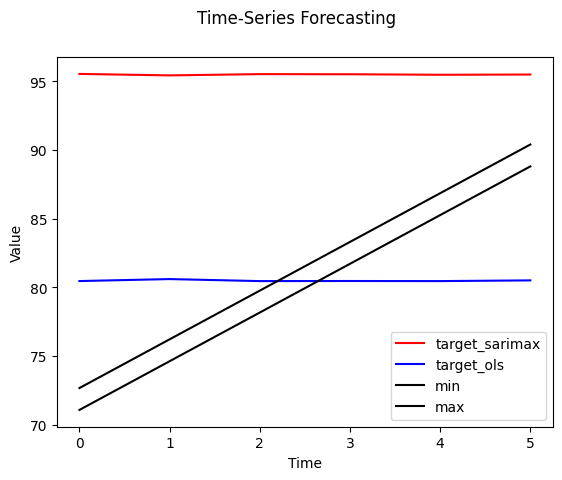

In [103]:
#PLOT
print(dataset.X_reg_target)
#print(orig_train, orig_test)
plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
fig.suptitle('Time-Series Forecasting')
a=4
#plt.plot(X_test_exog_true, label='exog1')#data[look_back+1:][0]
ax.plot(orig_targets_sarimax[a], label='target_sarimax', color='r')
#ax.plot(targets_orig_gru[a], label='target_gru', color='g')
ax.plot(orig_targets_ols[a], label='target_ols', color='b')
#ax.plot(hyper[a], label='actual', color='y')
ax.plot(min_bound_true_sarimax[a], label='min', color='black')
ax.plot(max_bound_true_sarimax[a], label='max', color='black')
plt.xlabel('Time')
plt.ylabel('Value')
#ax.title('Time-Series Forecasting')
plt.legend()
plt.show()
#Y_preds_original_gru, min_bound_true, max_bound_true
fig.savefig("forecasting.png")

In [102]:
#euclidean sarimax
def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)

print(targets_sarimax)
euclidean_min_sarimax = np.empty(targets_sarimax.shape[0])
euclidean_max_sarimax = np.empty(targets_sarimax.shape[0])

for i in range(targets_sarimax.shape[0]):
    dist_min = euclidean_distance(min_bound_sarimax[i], targets_sarimax[i])
    dist_max = euclidean_distance(targets_sarimax[i], max_bound_sarimax[i])
    euclidean_min_sarimax[i] = dist_min
    euclidean_max_sarimax[i] = dist_max
print(euclidean_min_sarimax, euclidean_max_sarimax)

[[0.04803511 0.04805129 0.04802515]
 [0.28887001 0.29484999 0.28967702]
 [0.48410547 0.49343023 0.48426723]
 [0.49688476 0.4906109  0.4925696 ]
 [0.29174536 0.28826046 0.29097334]
 [0.37921894 0.37637594 0.36737365]
 [0.3888365  0.40690455 0.38786462]
 [0.47111937 0.46695161 0.46119604]
 [0.20349516 0.2038811  0.20452966]
 [0.03804984 0.03531848 0.03726485]
 [0.33410016 0.32539505 0.33084017]
 [0.93236345 0.93238455 0.93237901]
 [0.49199939 0.49539444 0.49109414]
 [0.25366864 0.25467569 0.25595367]
 [0.32961002 0.33979481 0.34045994]
 [0.2867519  0.28721434 0.28575826]
 [0.31054059 0.31351292 0.31609088]
 [0.05942887 0.05809796 0.05679686]
 [0.02337039 0.02246145 0.02158786]
 [0.05688405 0.05322884 0.04980849]
 [0.10322179 0.10310026 0.10297886]
 [0.43593714 0.4423106  0.44648808]
 [0.3213641  0.32560173 0.32702127]
 [0.12850612 0.1285608  0.12867589]
 [0.44454801 0.44751856 0.44641823]
 [0.15855896 0.15838341 0.15819342]
 [0.26378784 0.26392221 0.262054  ]
 [0.20255734 0.20218115 0.20

[0.02028397 0.0124799  0.0218178  0.01600088 0.0143599  0.02082806
 0.05331216 0.01878163 0.01391518 0.02058719 0.01266659 0.0587553
 0.01909731 0.01191581 0.01914381 0.01161779 0.01602406 0.45123177
 0.18448043 0.59817083 0.04747685 0.02641222 0.01097527 0.02014586
 0.02668011 0.01547521 0.01487934 0.01300623 0.0234077  0.0161217
 0.01394247 0.00786219 0.0343665  0.01707048 0.86023133 0.26833321
 1.16715997 0.59533703 0.02826108 0.01532851 0.02024556 0.03434584
 0.02989058 0.01330056 0.02018582 0.03809685 0.01235369 0.02005804
 0.02704346 0.01340875 0.02273976 0.03839698 0.01585684 0.0176941
 0.02364622 0.01467906 0.01282532 0.02772512 0.01384833 0.01951273
 0.02516148 0.01638782 0.0188403  0.02368737 0.02423896 0.04290555
 0.01502444 0.012746   0.02173757 0.01834505 0.01426037 0.00965081
 0.02503647 0.03758536 0.02083805 0.0125627  0.01598076 0.0171104
 0.03391163 0.01661838 0.01548361 0.01341732 0.03524628 0.01521882
 0.01984023 0.0148944  0.01730026 0.01278154 0.01953597 0.01217559

<Figure size 1200x600 with 0 Axes>

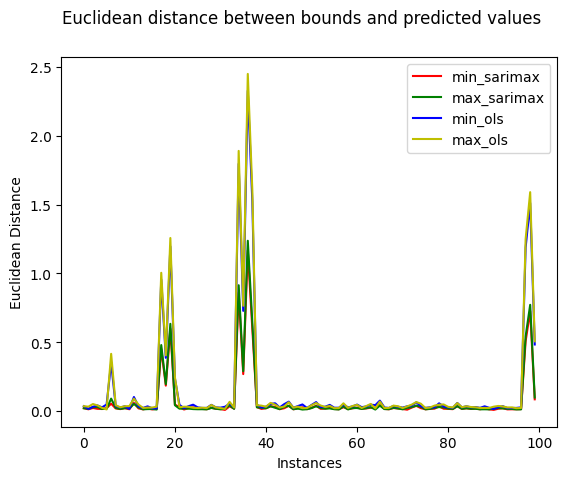

In [108]:
print(euclidean_min_sarimax, euclidean_max_sarimax, euclidean_min_ols, euclidean_max_ols)
plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
fig.suptitle('Euclidean distance between bounds and predicted values')
ax.plot(euclidean_min_sarimax, label='min_sarimax', color='r')
ax.plot(euclidean_max_sarimax, label='max_sarimax', color='g')
ax.plot(euclidean_min_ols[:,0], label='min_ols', color='b')
ax.plot(euclidean_max_ols[:,0], label='max_ols', color='y')
plt.xlabel('Instances')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.show()
fig.savefig("euclidean.png")

In [123]:
#RMSE sarimax 
def rmse(Y_test, Y_pred):
    return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
exogs_orig_sarimax = np.empty(len(CHANGE_COLS))   
exogs_orig = np.empty(len(CHANGE_COLS))   
rmse_sarimax = np.empty(len(CHANGE_COLS)) 
print(exogs_sarimax, pred_exog[rand_test_idx])

for i in range(exogs_sarimax.shape[0]):
    # Compute RMSE
    rmse_sarimax = (rmse(exogs_sarimax[i], pred_exog[rand_test_idx][i]))

print(rmse_sarimax)

                        




[[[0.2234152  0.22414255 0.22704691 0.22289771]
  [0.22349045 0.22023079 0.2220467  0.22022924]
  [0.22336887 0.22268419 0.22349642 0.22462295]]

 [[1.80326569 1.80380714 1.80460918 1.80333817]
  [1.77880669 1.7773248  1.7772404  1.77764893]
  [1.80586481 1.80542767 1.8062675  1.80582011]]

 [[2.85609913 2.85741472 2.85825658 2.85668397]
  [2.69963241 2.69779515 2.69747329 2.69838071]
  [2.85532689 2.85415673 2.85565114 2.85466361]]

 ...

 [[0.49622399 0.49427059 0.49682859 0.49366501]
  [0.49490559 0.49380869 0.49447387 0.49419609]
  [0.49025622 0.49152571 0.49242917 0.49446714]]

 [[0.57767344 0.57729149 0.57904565 0.57724881]
  [0.5959518  0.5960415  0.59485132 0.59483784]
  [0.60674083 0.60655469 0.60770011 0.60528904]]

 [[0.55040991 0.55122119 0.55151546 0.5498969 ]
  [0.56218064 0.56065977 0.56073219 0.56177175]
  [0.56808305 0.56753528 0.57006675 0.56970239]]] [[[0.7000096  0.70073694 0.7036413  0.6994921 ]
  [0.6914421  0.6881825  0.6899983  0.68818086]
  [0.6789474  0.678262

In [ ]:
#OLD CODE

In [ ]:
#NBEATS
import tensorflow as tf
from nbeats_keras.model import NBeatsNet

# Prepare the data
X = dataset.X_train_exog  # Shape: (num_samples, back_horizon, num_features)
y = dataset.X_train_target  # Shape: (num_samples, horizon)

# Set random seed for reproducibility
tf.random.set_seed(args.random_seed)

# Define model hyperparameters
horizon, back_horizon = args.horizon, args.back_horizon

# Create the N-BEATSx model
nbeats_model = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=horizon,
    backcast_length=back_horizon,
    hidden_layer_units=256,
)

# Compile the model
nbeats_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="mae"
)

# Train the model
nbeats_model.fit(X, y, epochs=100, verbose=0)

# Make predictions
pred_nbeats = nbeats_model.predict(dataset.X_test_exog)  # Predictions on the test set
print(pred_nbeats)

mean_smape, mean_rmse = forecast_metrics(dataset, pred_nbeats)
print(
    f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

In [ ]:
#statistical
from statsmodels.tsa.statespace.sarimax import SARIMAX

#orig_train = orig_train.dropna()
#orig_test = orig_test.dropna()
#endog = orig_train[orig_train.patient_id==544].glucose
#exog = orig_train[orig_train.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#exog_pred = orig_test[orig_test.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#endog_pred = orig_test[orig_test.patient_id==544].glucose
#print(orig_test, endog_pred)
#print(np.asarray(endog), np.asarray(exog))
print(y[0],X[0])
mod = sm.tsa.SARIMAX(endog=np.asarray(y[0]), exog=np.asarray(X[0]), order=(1,0,0))
#res = mod.fit(disp=False)
mod = mod.fit(disp=False)
start_params = mod.params
print(mod.summary())
pred = mod.forecast(horizon, start_params=start_params, exog=np.asarray(dataset.X_test_exog[0])[-horizon:])
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(dataset.X_test_exog[0])[-horizon:]
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = mod.forecast(horizon, start_params=start_params, exog=exog_pred_change)
    print(pred)
    
print(pred)

In [ ]:
#regression
import statsmodels.api as sm

def mean_squared_error(y_true, y_predicted):
    # Calculating the loss or cost
    cost = np.sum((y_true-y_predicted)**2) / len(y_true)
    return cost
    
orig_train = orig_train.dropna()
orig_test = orig_test.dropna()
endog = orig_train[orig_train.patient_id==591].glucose
exog = orig_train[orig_train.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
exog_pred = orig_test[orig_test.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
endog_pred = orig_test[orig_test.patient_id==591].glucose
print(orig_test, endog_pred)
print(np.asarray(endog), np.asarray(exog))
forest = sm.OLS(np.asarray(endog), np.asarray(exog)).fit()
pred = forest.predict(np.asarray(exog_pred))
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(exog_pred)
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = forest.predict(exog_pred_change)
    print(pred)
    
print(pred)